# Лекция 5. Временные последовательности

## Введение

- Объекты приходят последовательно во времени
- Хотим предсказывать какую-то информацию об объектах, которая будет в далёком будущем
- Фиксированный (обычно во времени) порядок всех объектов (отличие от обычной задачи предсказания)
- Может быть как задачей регрессии, так и задачей классификации
- В данной лекции будет рассматриваться только случай регрессии. Переход к классификации не должен составить труда

$y_0, y_1, y_2, ..., y_n$ &#151; временной ряд, $y_i \in \mathbb{R}$ &#151; значение, полученное через **постоянный** временной интервал.

$y_{T+d} \approx f_T(y_0, y_1, ..., y_T, \theta, d), d = 1, ..., D$ &#151; модель временного ряда,

где $\theta$ &#151; параметры модели, $D$ &#151; горизонт прогнозирования. 

При $K = 1$ хотим предсказывать только одно следующее значение, в противном случае предсказываем упорядоченный набор $y_{t+1}, y_{t+2}, ..., y_{t+K}$.

В классической задаче анализа данных мы предполагаем независимость всех наблюдений. В случае анализа временных рядов мы исходим из гипотезы о том, что предсказанные значение не будут зависеть от предыдущих.

## Пример задача прогнозирования:

1. курс валюты;
2. стоймость акций компании "Яндекс";
3. спрос на определённый продукт;
4. количество студентов без долгов в определенный момент времени;
5. процент посещаемости лекций по мат. анализу;
6. уровень безработицы;
7. ...

## Термины из области анализа временных рядов:

1. тренд;
2. сезонность, цикл;
3. ошибка.

In [1]:
from IPython.display import Image

### Тренд &#151; изменение значений ряда в долгосрочной преспективе

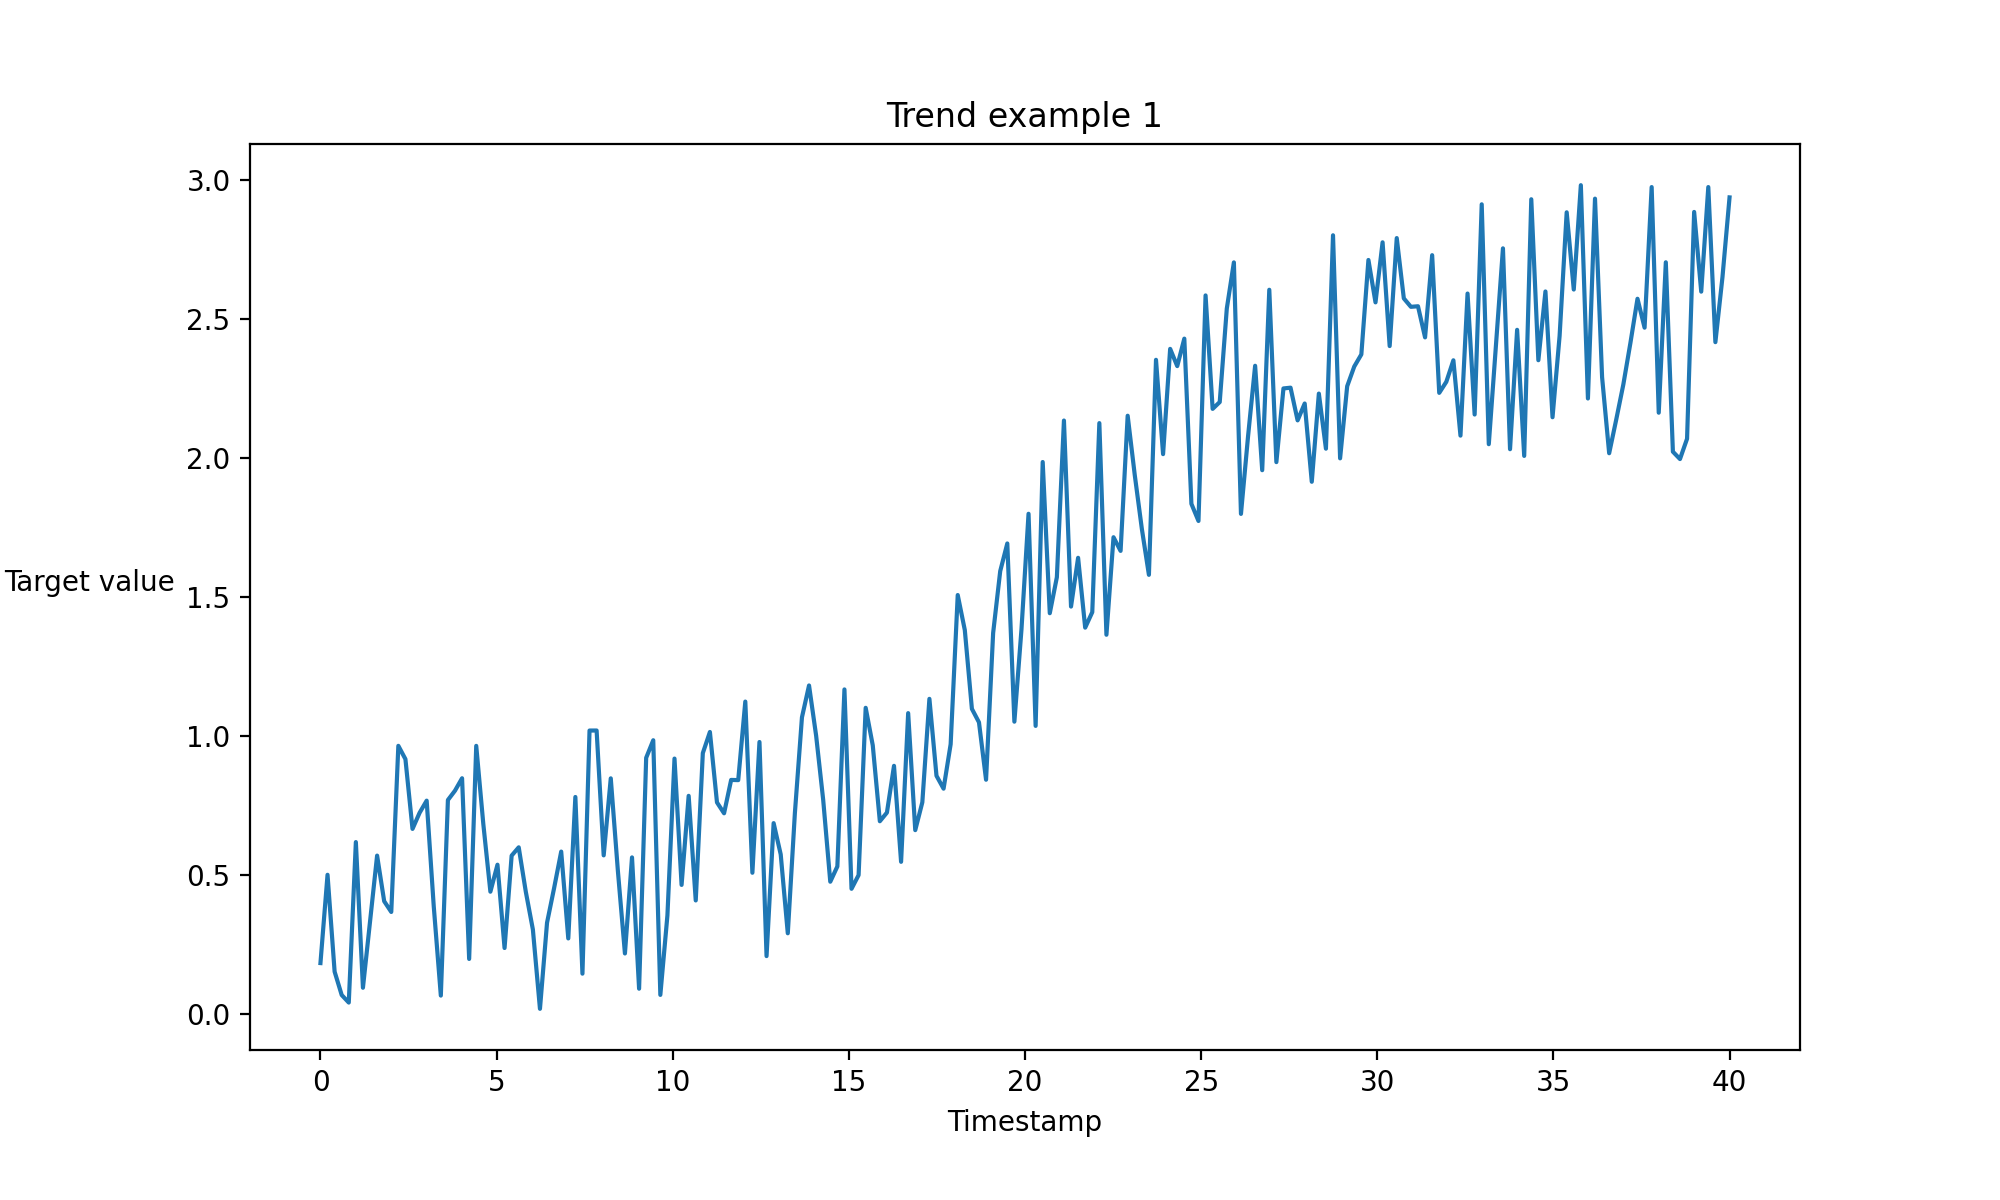

In [2]:
Image('./example_1.png')

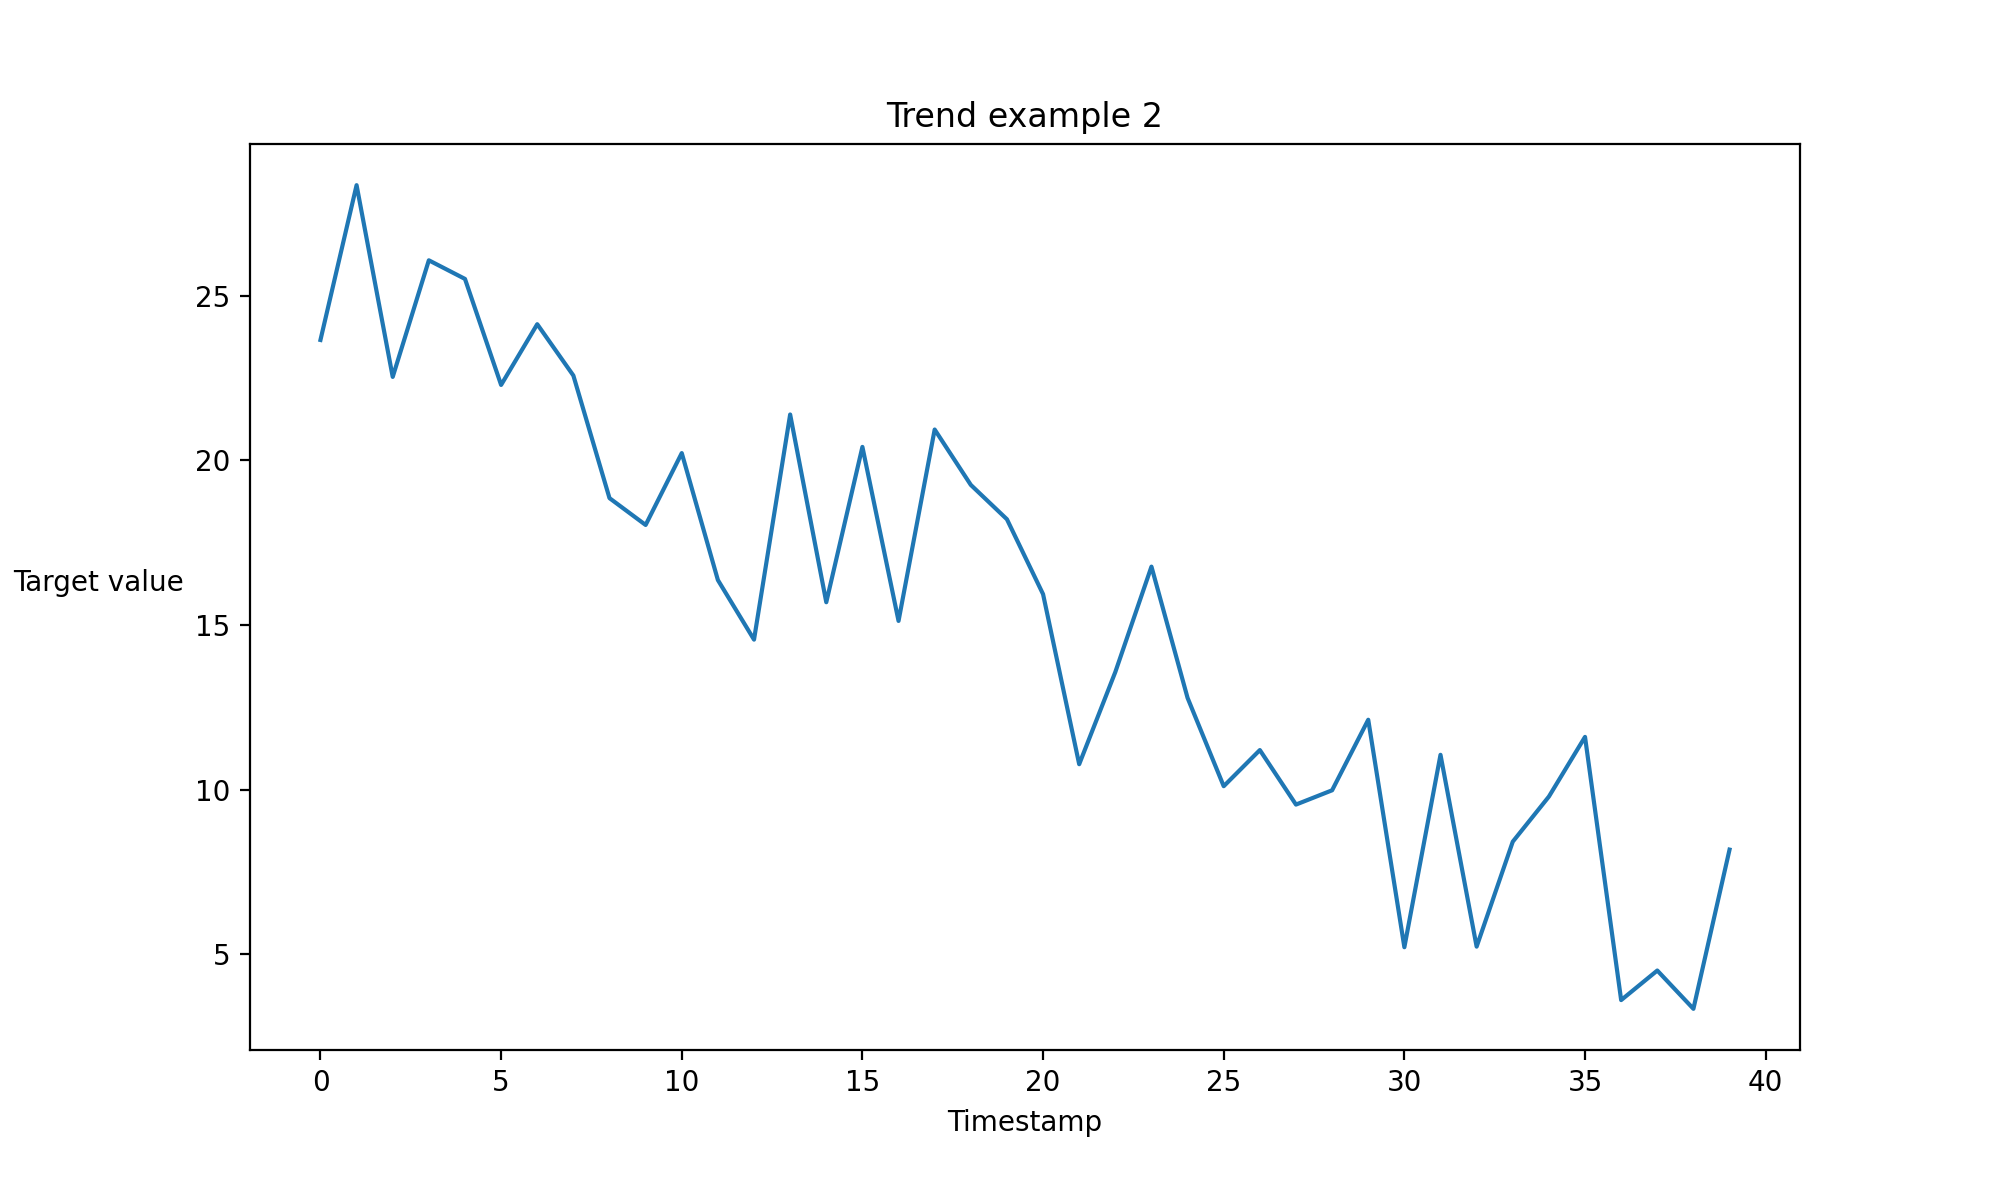

In [3]:
Image('./example_2.png')

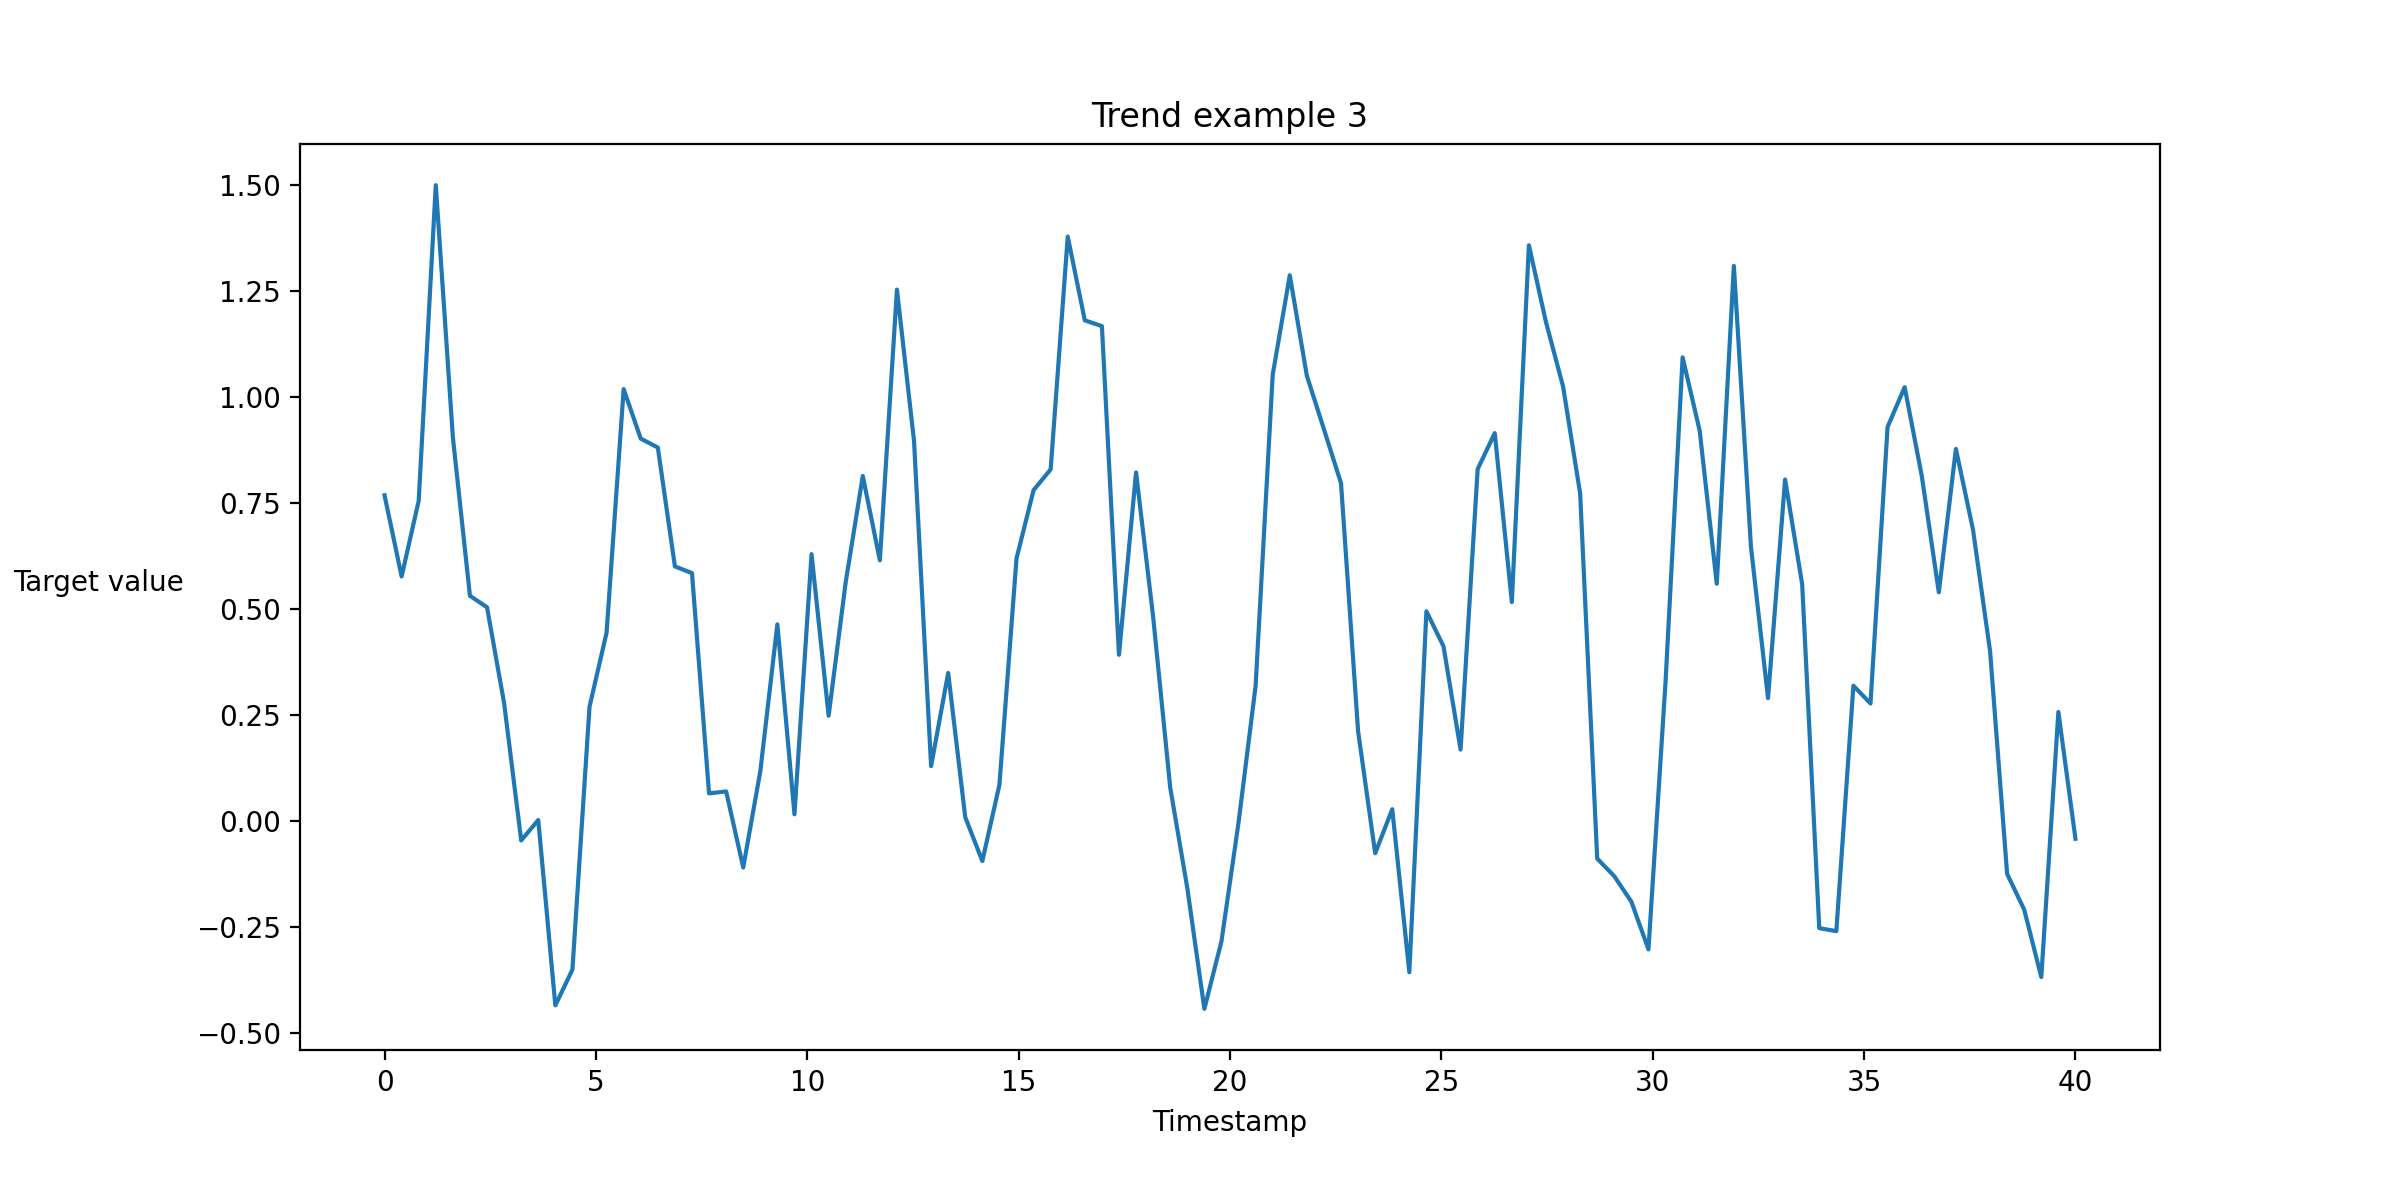

In [4]:
Image('./example_3.png')

### Сезонность &#151; циклические изменения значений ряда с *определённым* периодом

### Цикл &#151; циклические изменения значений ряда с *изменяемым* периодом

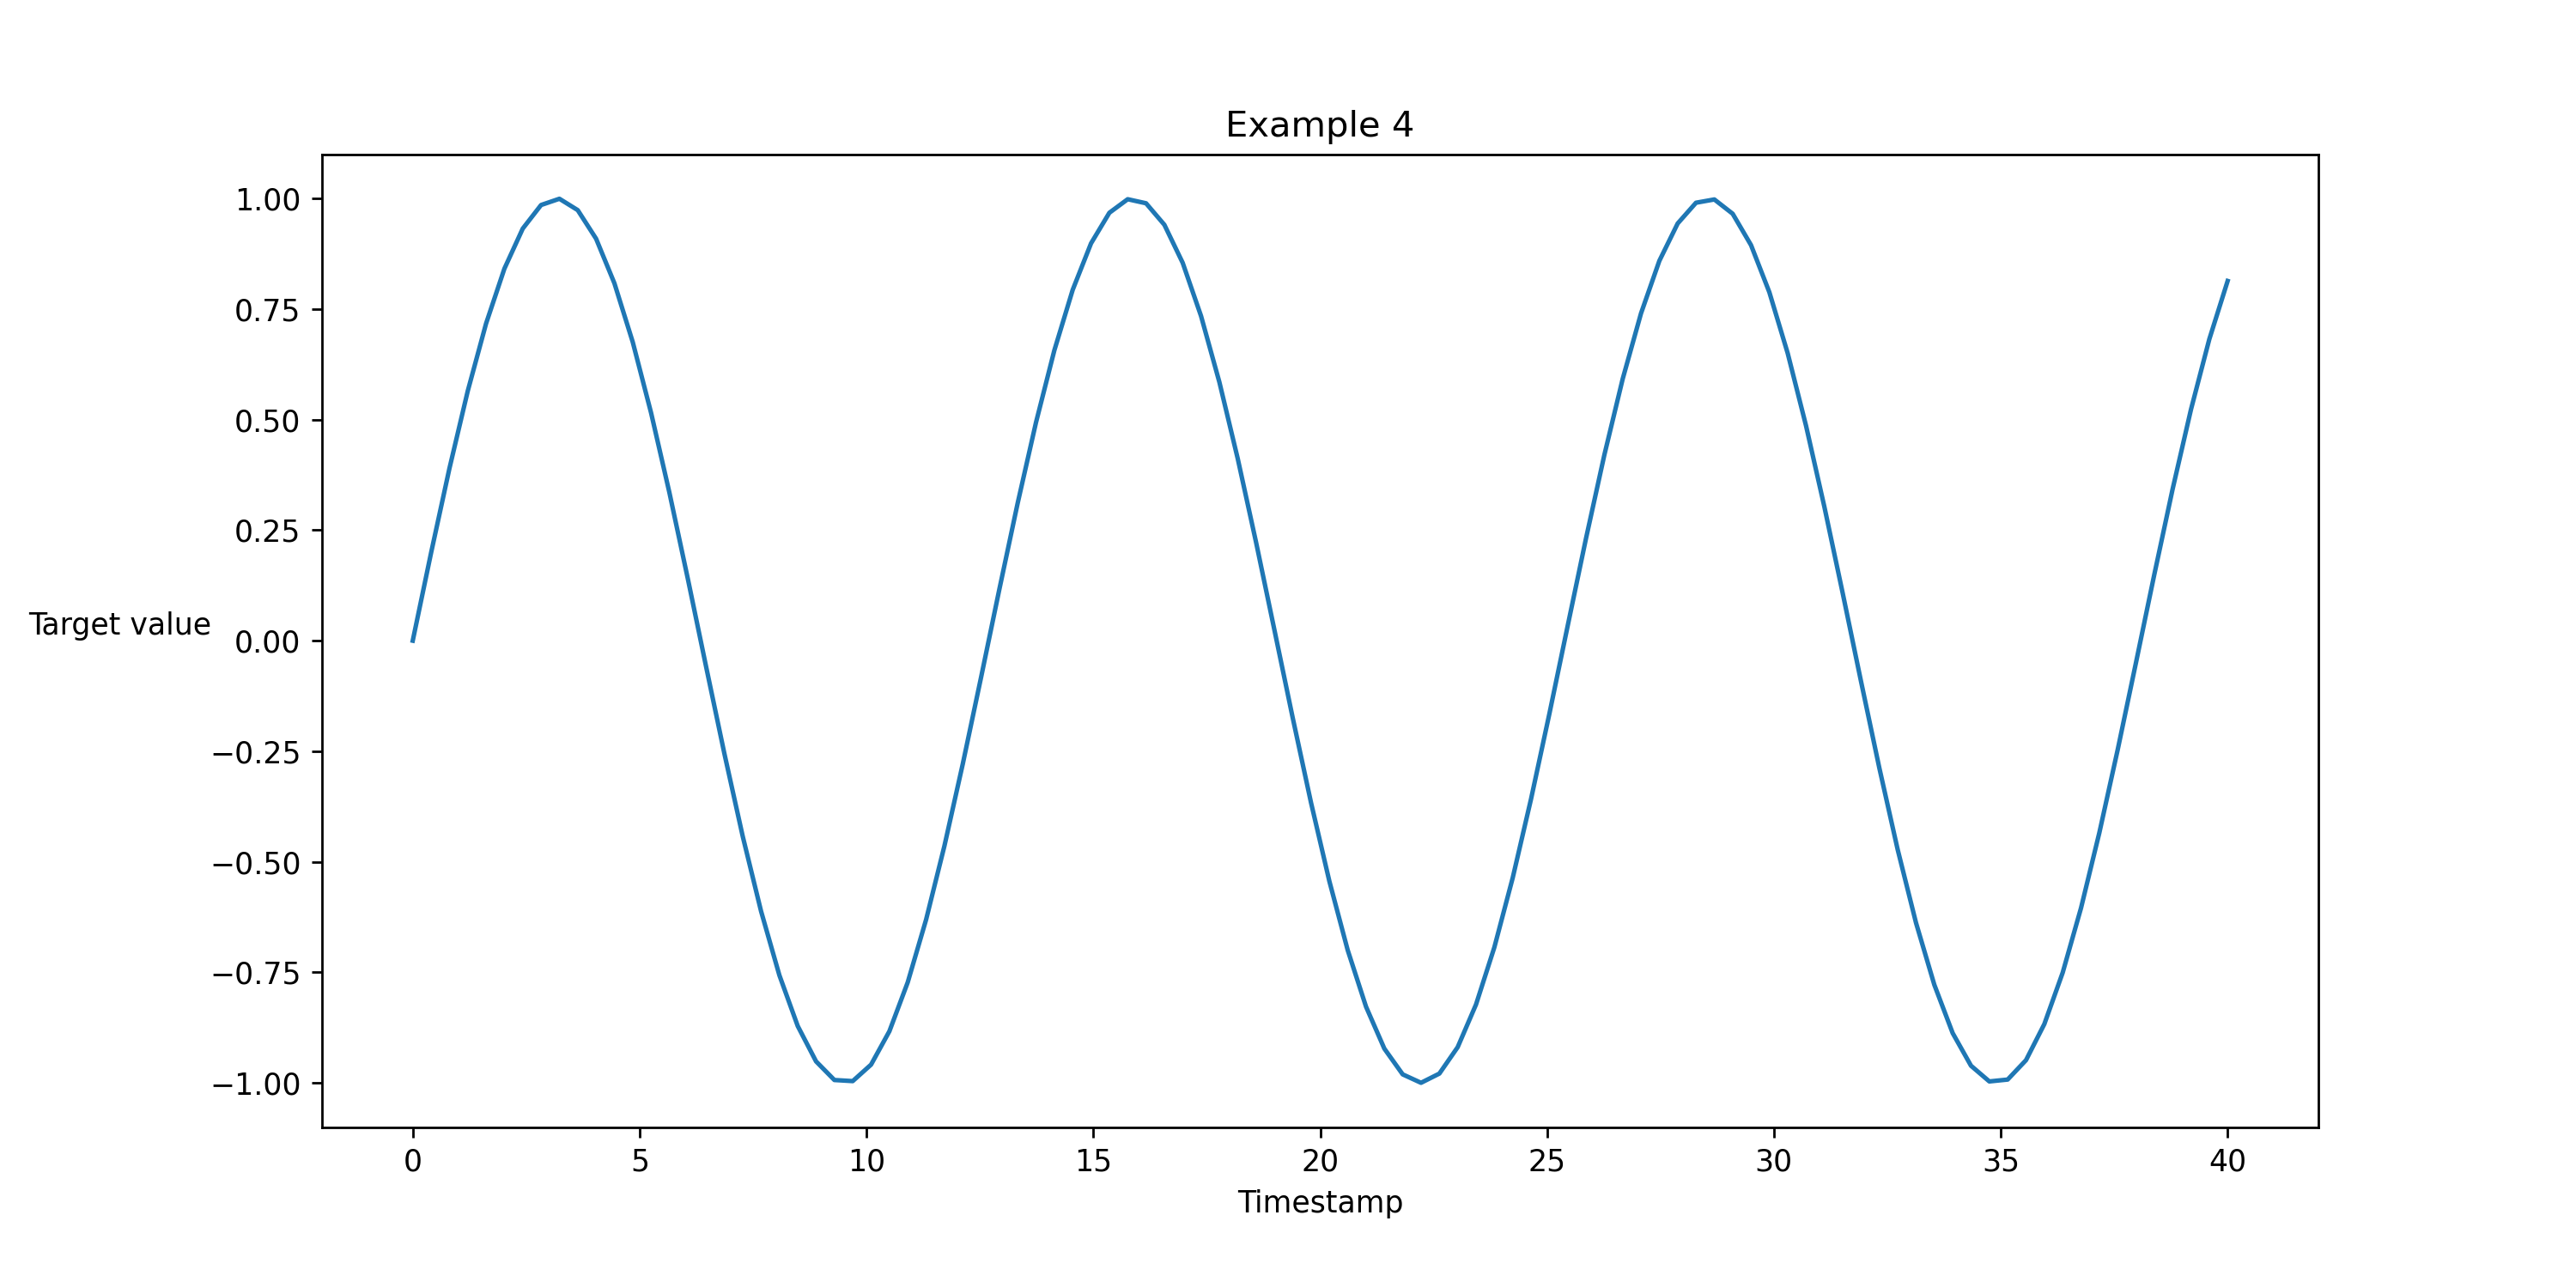

In [5]:
Image('./example_4.png')

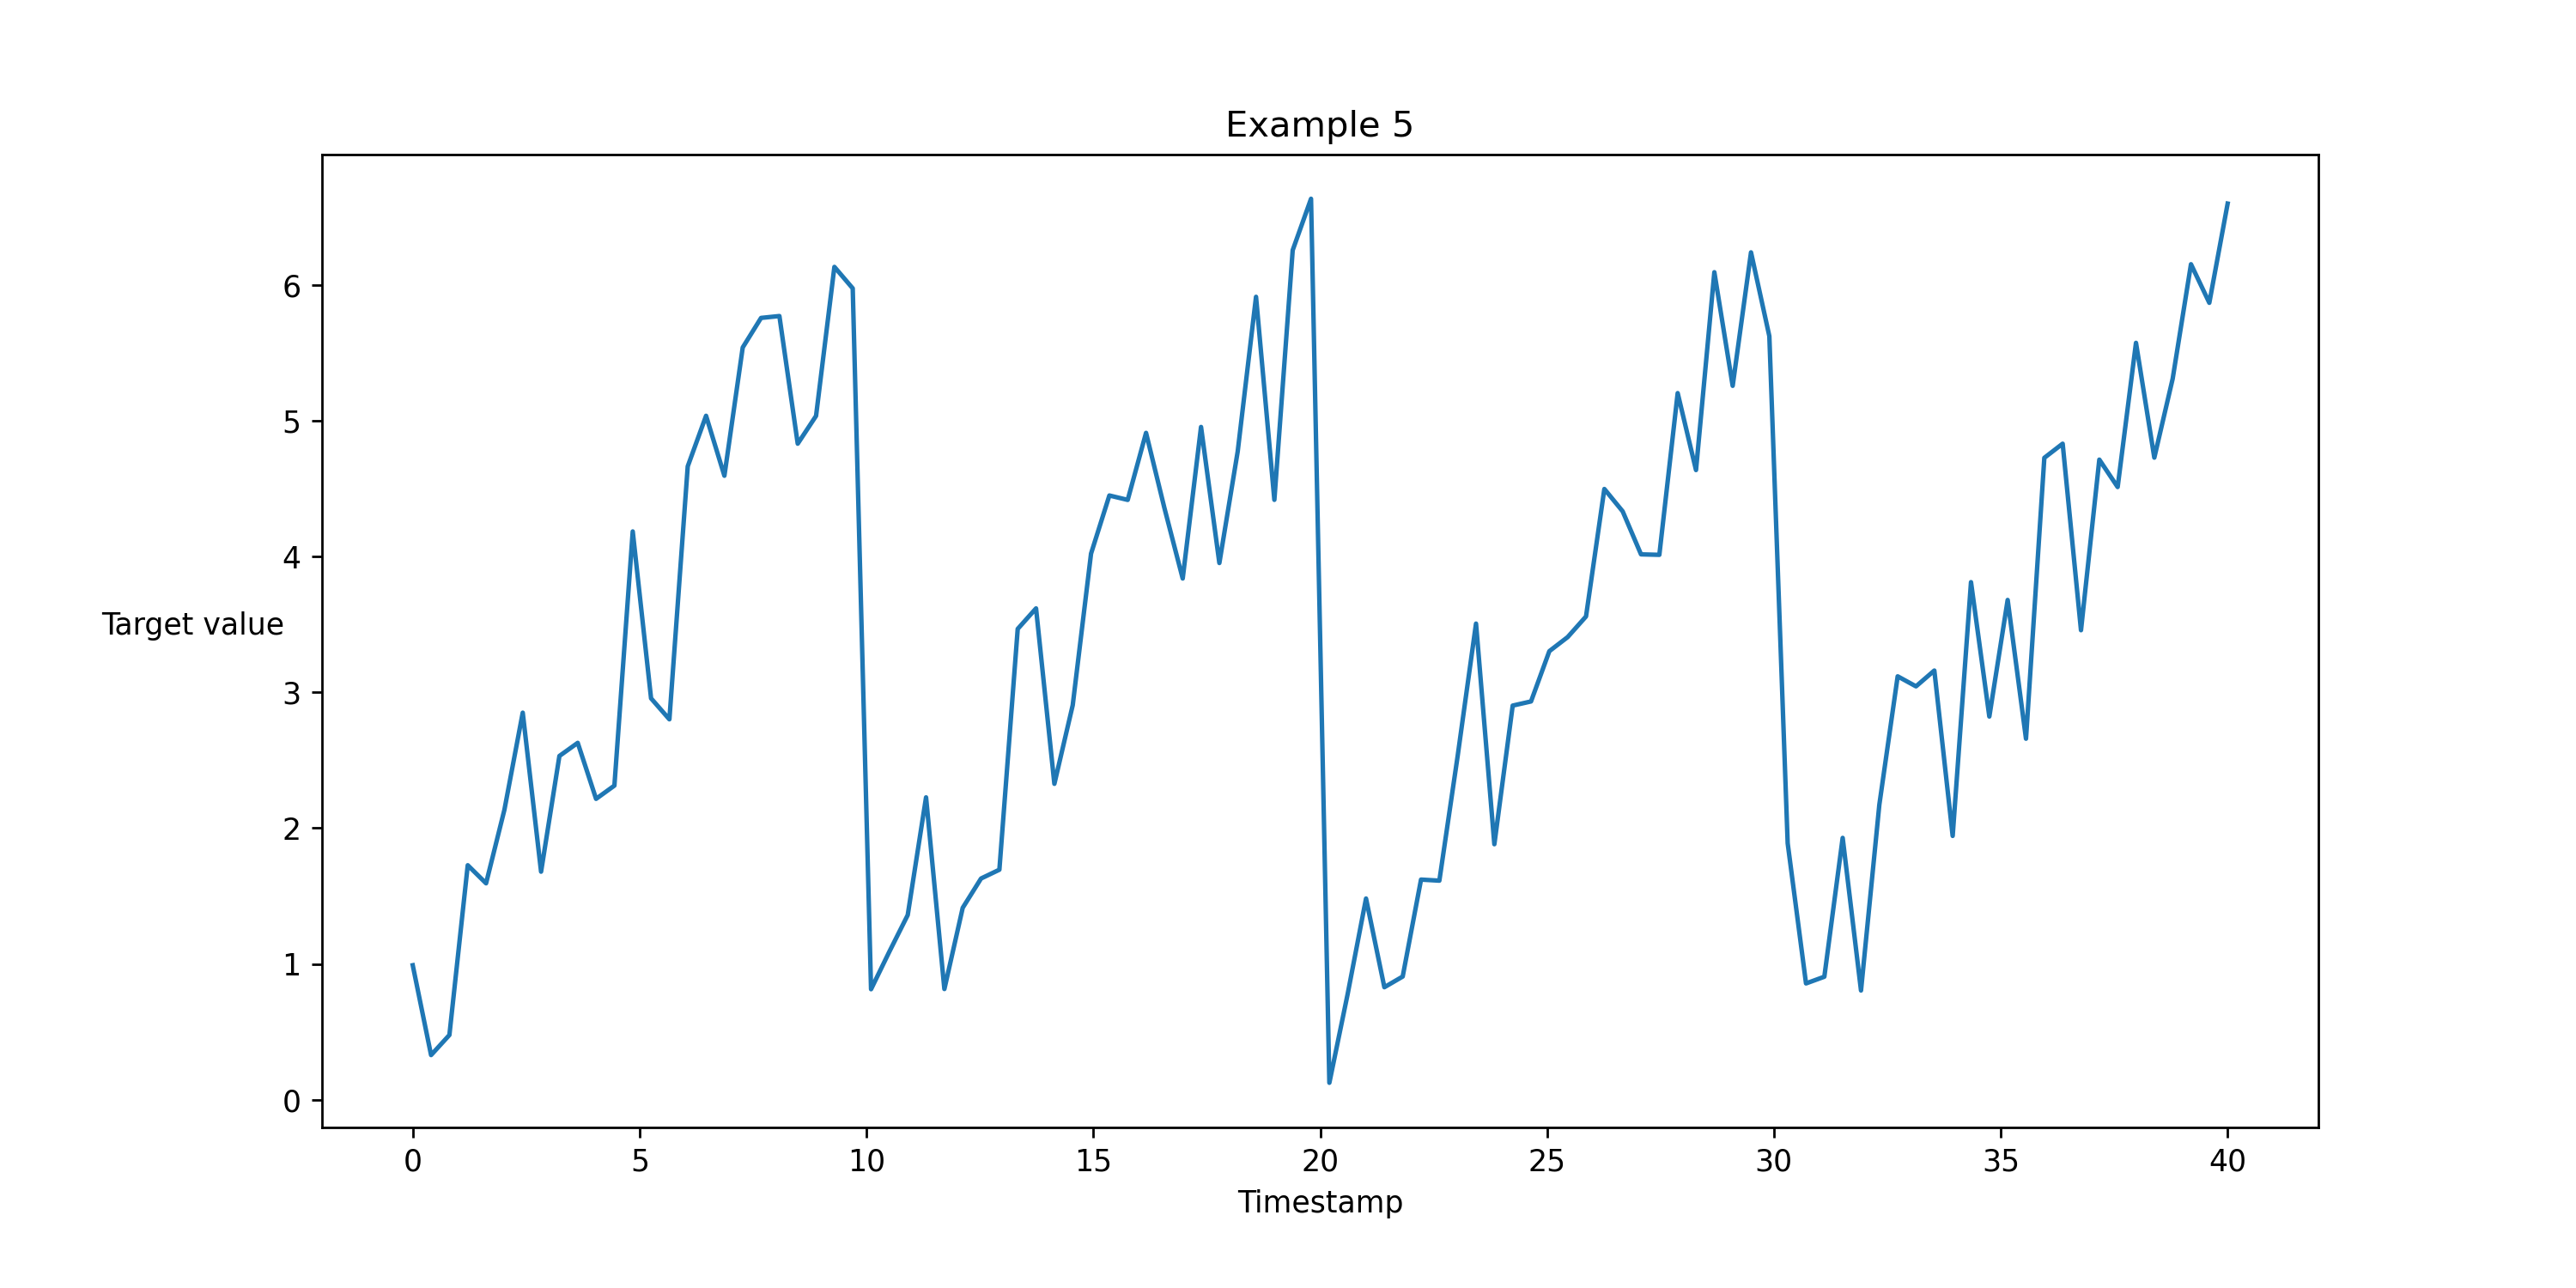

In [6]:
Image('./example_5.png')

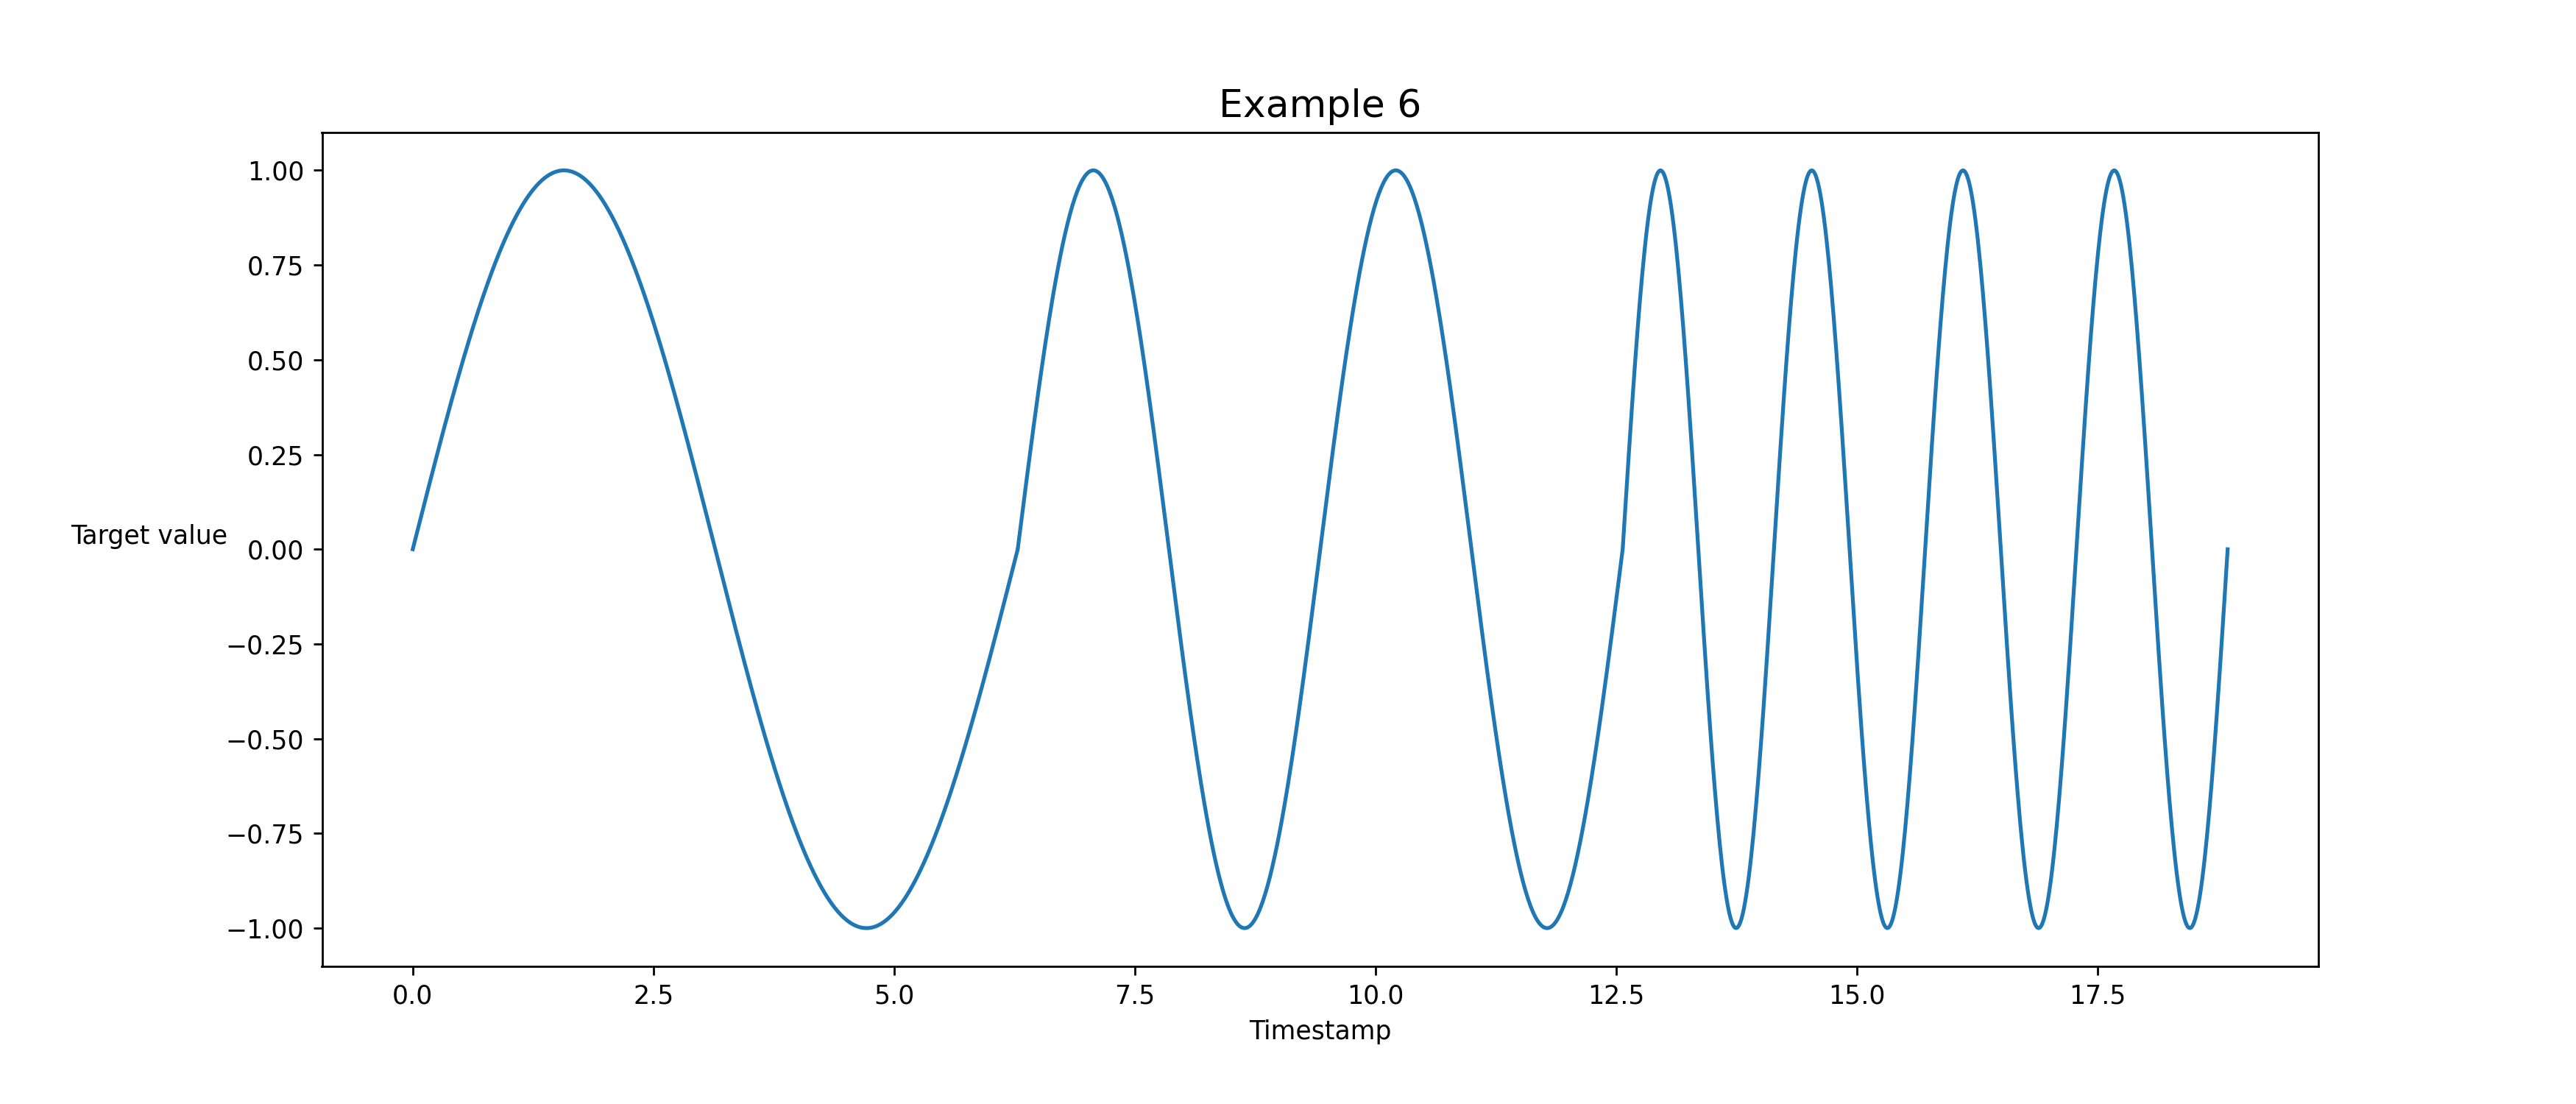

In [7]:
Image('./example_6.png')

### Ошибка &#151; непрогнозируеммая величина, шум.

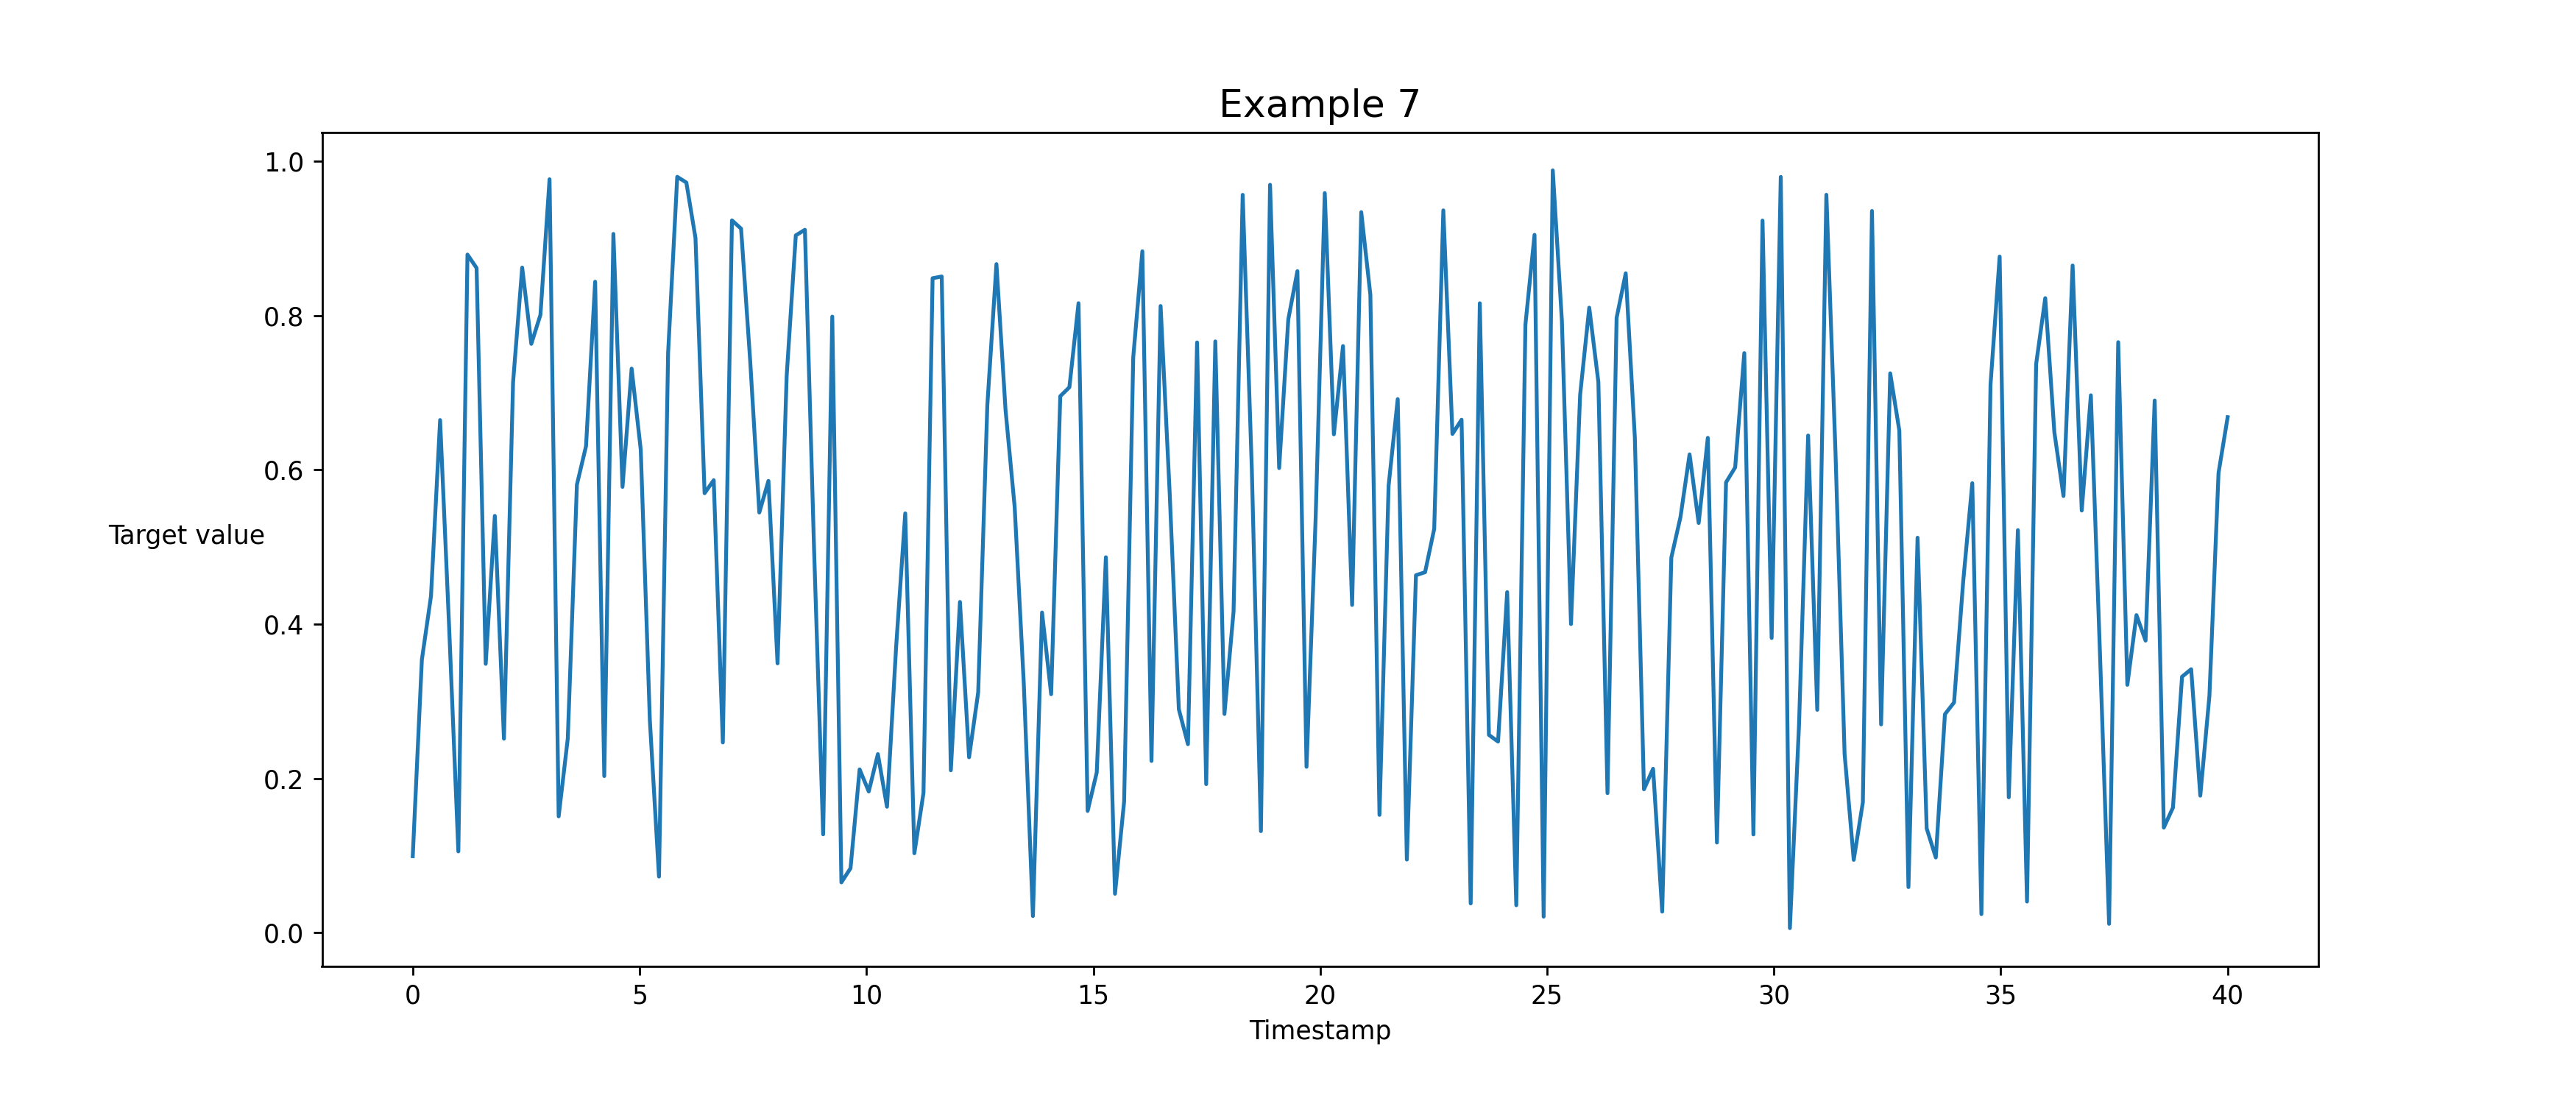

In [8]:
Image('./example_7.png')

## Пример временного ряда:

In [9]:
# Импорт необходимых библиотек
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

In [10]:
df = pd.read_csv('./example_data_1.csv')
df.head(13)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
5,4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861
6,4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002
7,4/13/2015 16:00:00,41.40,42.06,41.39,41.76,30276692
8,4/14/2015 16:00:00,41.80,42.03,41.39,41.65,24244382
9,4/15/2015 16:00:00,41.76,42.46,41.68,42.26,27343581


In [11]:
df.shape

(1511, 6)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [13]:
# Проанализируем базовые статистики имеющихся признаков
df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


In [14]:
# Привидём время к типу 'datetime' и сделаем его индексом для датасета
df['Date'] = df['Date'].str[:-9]
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df = df.set_index(['Date'])
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01,40.60,40.76,40.31,40.72,36865322
2015-04-02,40.66,40.74,40.12,40.29,37487476
2015-04-06,40.34,41.78,40.18,41.55,39223692
2015-04-07,41.61,41.91,41.31,41.53,28809375
2015-04-08,41.48,41.69,41.04,41.42,24753438


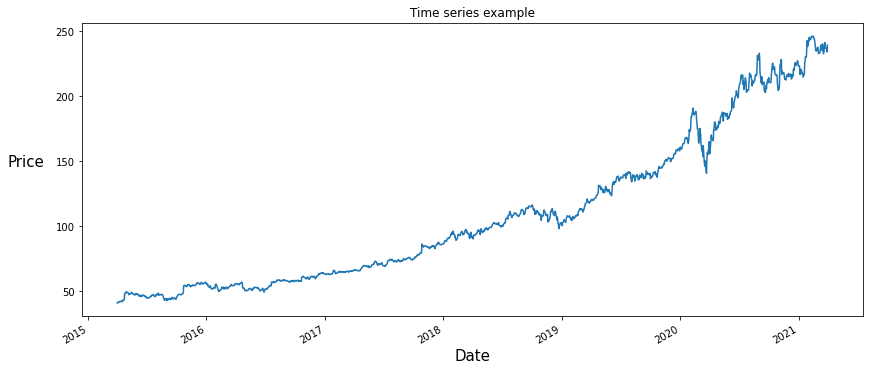

In [15]:
# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
plt.title('Time series example')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['High'].plot();

Вопросы:
- Есть ли у данного ряда тренд? 
- Есть ли у данного ряда сезонность?

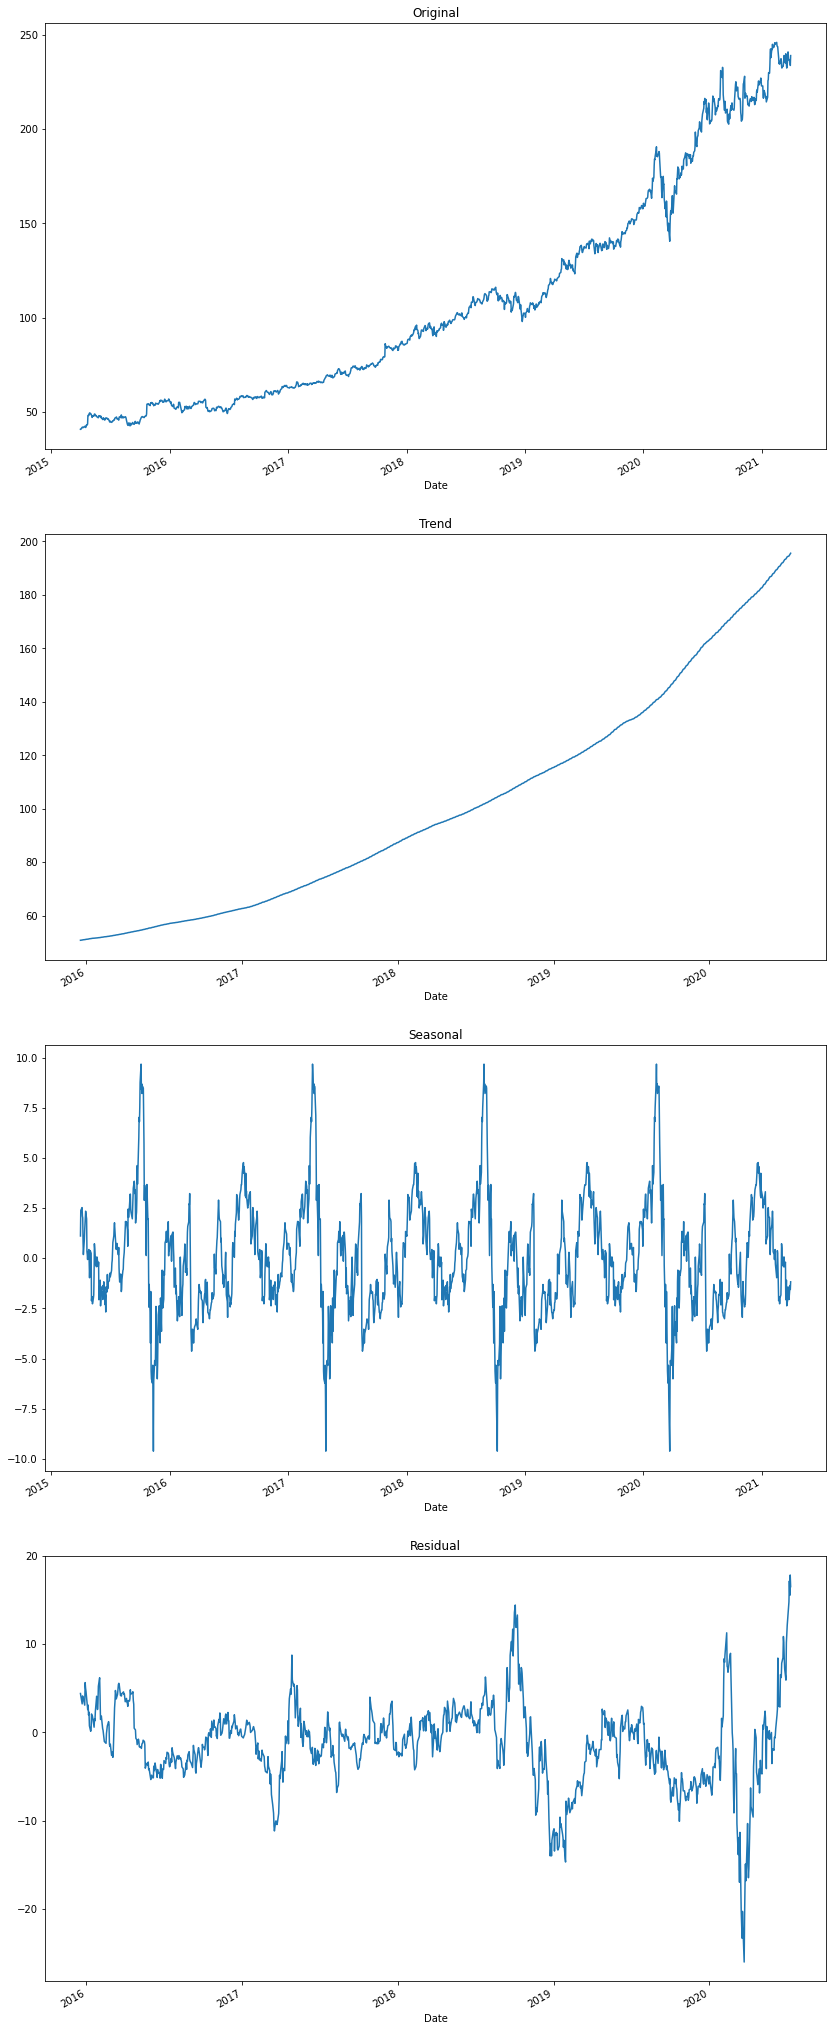

In [16]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['High']], period=365)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Для последующего анализа нам потребуется ввести термин "Автокорреляция", который позволит нам более подробно изучить свойства временных рядов

## Автокорреляция

### Автокорреляция &#151; мера силы линейной связи между значениями ряда в настоящем или прошлом

###  $$r_t = \frac{\mathbb{E}((y_t - \mathbb{E}y)(y_{t + \tau} - \mathbb{E}y))}{\mathbb{D}y}$$ 
$\tau$ &#151; лаг автокорреляции

$r_t \in [-1; 1]$

In [17]:
# Получил 'сырые' значения автокорреляций
acf(df['High'], nlags=60, fft=False)

array([1.        , 0.99731297, 0.99473112, 0.99217976, 0.98963531,
       0.9870081 , 0.98436634, 0.98175292, 0.97924728, 0.97678189,
       0.97422961, 0.97161367, 0.96900906, 0.96654264, 0.96405245,
       0.96156436, 0.95912885, 0.95680326, 0.95447423, 0.95213003,
       0.94982489, 0.94747191, 0.94503718, 0.94263203, 0.94029695,
       0.9380034 , 0.9357559 , 0.93359641, 0.9313129 , 0.92885744,
       0.92639949, 0.92389073, 0.92130192, 0.91873259, 0.91611182,
       0.91350324, 0.91094004, 0.90837329, 0.90575782, 0.90312879,
       0.90041777, 0.89779644, 0.89517102, 0.89270675, 0.89016427,
       0.88773363, 0.88541656, 0.88317637, 0.88097815, 0.87886754,
       0.87667588, 0.87463272, 0.87265267, 0.87063094, 0.86857136,
       0.86646921, 0.86435525, 0.86218978, 0.86006919, 0.85798617,
       0.85583765])

На самом же деле, с автокорреляциями удобнее работать имея перед глазами график, поэтому далее нам необходимо рассмотреть коррелограммы

### Корелограммы

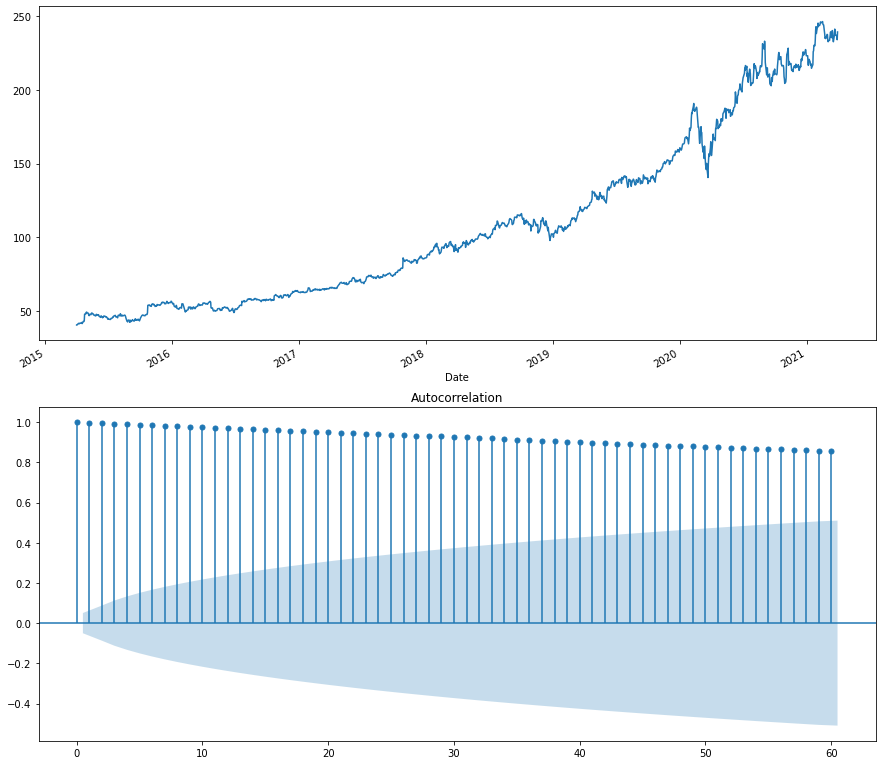

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df['High'].plot(ax=ax[0])
plot_acf(df['High'], lags=60, ax=ax[1]);

На втором графике каждый столбец -- значение автокорреляции, а зона, обозначенная синим, говорит о том, является ли определённая автокорреляция значимой (выходит из зоны) или нет (весь столбец находится в закрашенной области)

## Стационарность

Ряд $y_1, y_2, \cdots, y_T$ является **стационарным**, если для любого окна ширины $s$ распределение ряда $y_t, \cdots, y_{t+s}$ не зависит от выбора $t$

Некоторые полезные хинты для проверки ряда на стационарность:

- если у ряда есть тренд, то он нестационарен;
- если у ряда есть сезонность, то он нестационарен;
- если у ряда изменяется со временем дисперсия, то он нестационарен.

Есть ли критерий для проверки ряда на стационарность?

Ответ: Можно воспользоваться аппаратом проверки гипотез. В частности метод (тест) Дики-Фуллера

In [19]:
p_value = adfuller(df['High'])[1]
print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.9978. 0.9978 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!


Как сделать ряд стационарным?

- дифференцирование ряда (простое и сезонное);
- преобразование Бокса-Кокса;
- логарифмирование ряда (частный случай преобразования Бокса-Кокса).

### Попробуем привести ряд к стационарному

In [20]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01,40.60,40.76,40.31,40.72,36865322
2015-04-02,40.66,40.74,40.12,40.29,37487476
2015-04-06,40.34,41.78,40.18,41.55,39223692
2015-04-07,41.61,41.91,41.31,41.53,28809375
2015-04-08,41.48,41.69,41.04,41.42,24753438


In [21]:
df = df.drop(['Open', 'Low', 'Close', 'Volume'], axis=1)
df.head()

,High
Date,
2015-04-01,40.76
2015-04-02,40.74
2015-04-06,41.78
2015-04-07,41.91
2015-04-08,41.69


In [22]:
df['HighDiff_1'] = df['High'] - df['High'].shift(1) # Тут вроде можно использовать df['High'].diff(), но это не точно
df.head()

,High,HighDiff_1
Date,,
2015-04-01,40.76,NaN
2015-04-02,40.74,-0.02
2015-04-06,41.78,1.04
2015-04-07,41.91,0.13
2015-04-08,41.69,-0.22


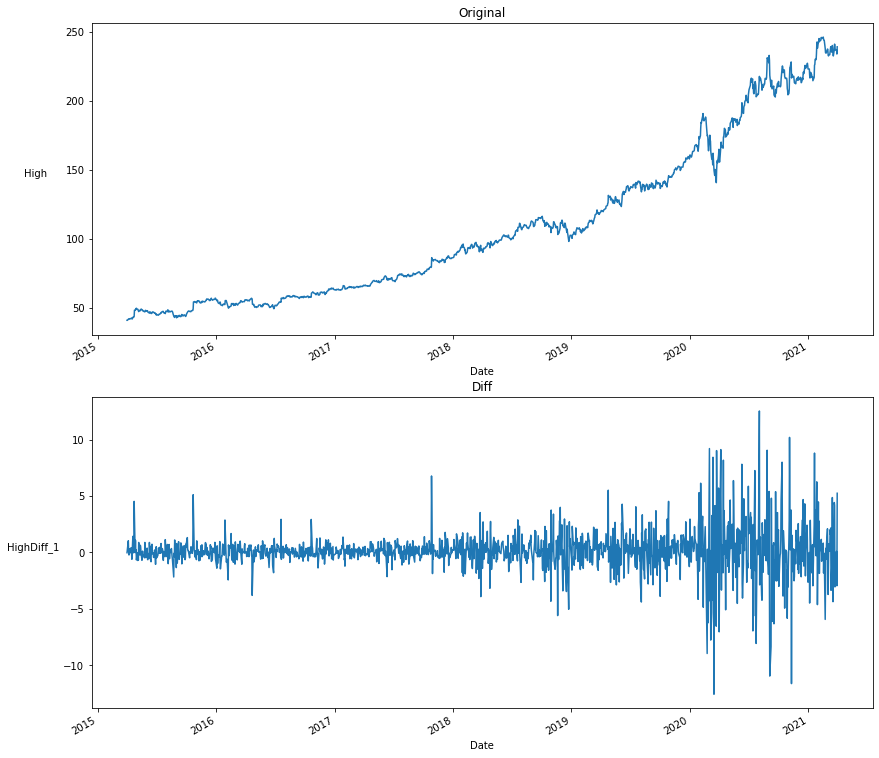

In [23]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('High', rotation=0, labelpad=30)
df['High'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('HighDiff_1', rotation=0, labelpad=30)
df['HighDiff_1'].plot(ax=ax);

In [24]:
# Проверим гипотезы для нового ряда

p_value = adfuller(df['HighDiff_1'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

# Но на самом деле ряд не стационарный (после 2020 года дисперсия увеличилась)
# Критерий не даёт нам 100-процентную гарантию, он просто может выступать в качестве первичной проверки

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


In [25]:
# Используем трюк с логарифмированием для уменьшения дисперсии и так же как и ранее составим диффериенцированный ряд
df['HighLog'] = np.log(df['High'])
df['HighLogDiff_1'] = df['HighLog'] - df['HighLog'].shift(1)
df.head()

,High,HighDiff_1,HighLog,HighLogDiff_1
Date,,,,
2015-04-01,40.76,NaN,3.707701,NaN
2015-04-02,40.74,-0.02,3.707210,-0.000491
2015-04-06,41.78,1.04,3.732418,0.025207
2015-04-07,41.91,0.13,3.735524,0.003107
2015-04-08,41.69,-0.22,3.730261,-0.005263


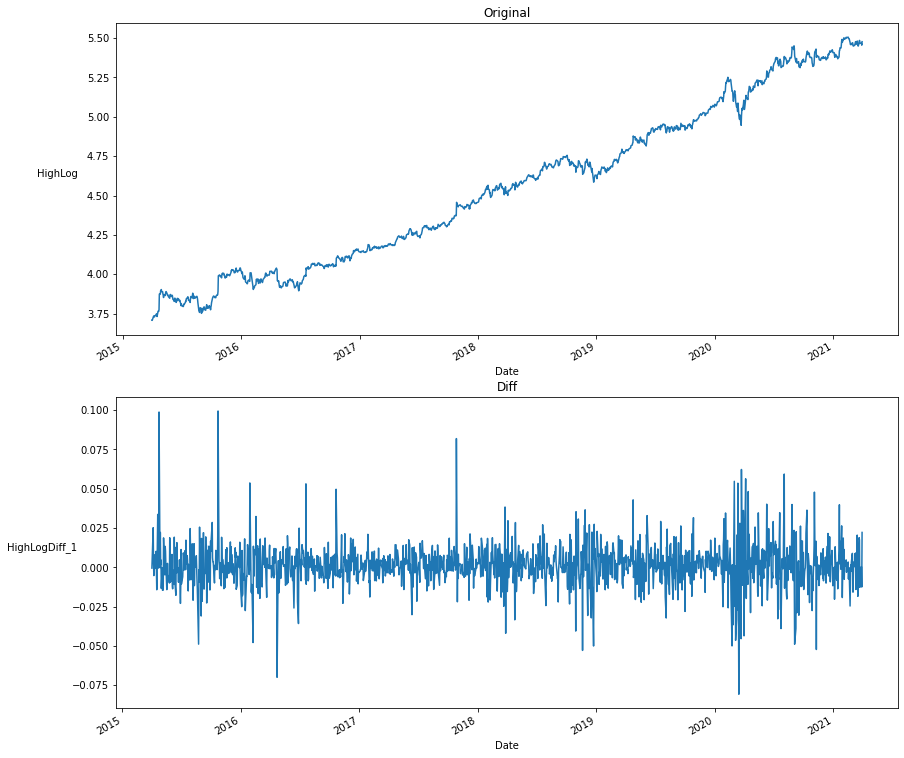

In [26]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('HighLog', rotation=0, labelpad=30)
df['HighLog'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('HighLogDiff_1', rotation=0, labelpad=30)
df['HighLogDiff_1'].plot(ax=ax);

In [27]:
p_value = adfuller(df['HighLogDiff_1'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)
# Тут, как и ранее, критерий говорит нам о том, что ряд стационарный, но теперь мы можем видеть это ещё и визуально
# Как вариант, можно взглянуть на распределение значений

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


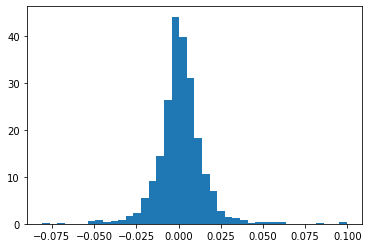

In [28]:
plt.hist(df['HighLogDiff_1'], density=True, bins=40);
# Как можно видеть распредение признака 'HighLogDiff_1' очень похоже на нормальное

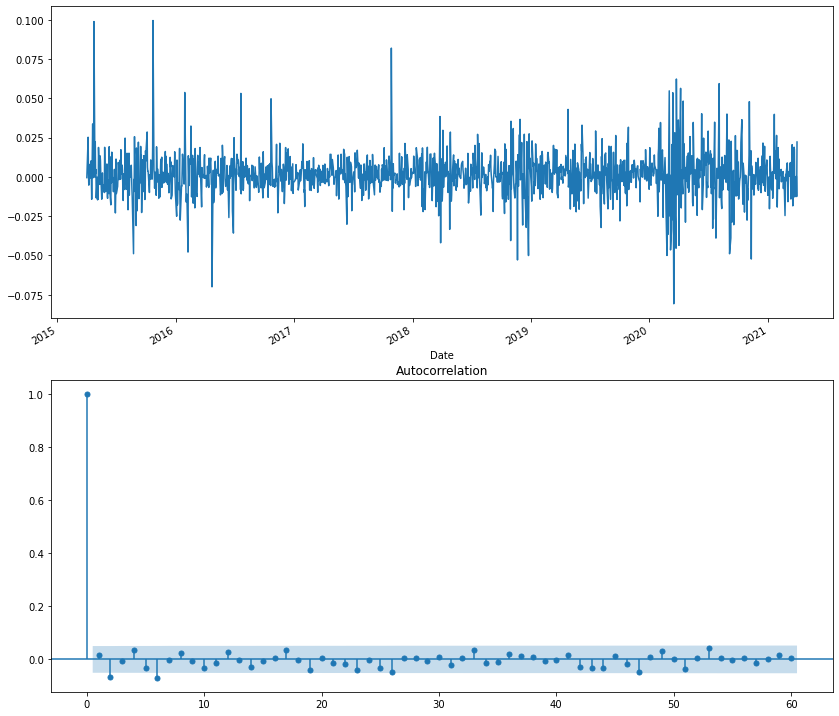

In [29]:
# Построим корелограмму и проверим наличие значимых коррелаций
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df['HighLogDiff_1'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['HighLogDiff_1'][1:], lags=60, ax=ax);

# Как можно видеть из графиков, среди 60 корреляций можно выделить только 2-3 значимый, при этом их значимость довольна мала
# Это может значить что ряд стационарет (опять-таки это скорее необходимое, но не достаточное требование к стационарности ряда)

## Примеры коррелограмм для синтетических данных

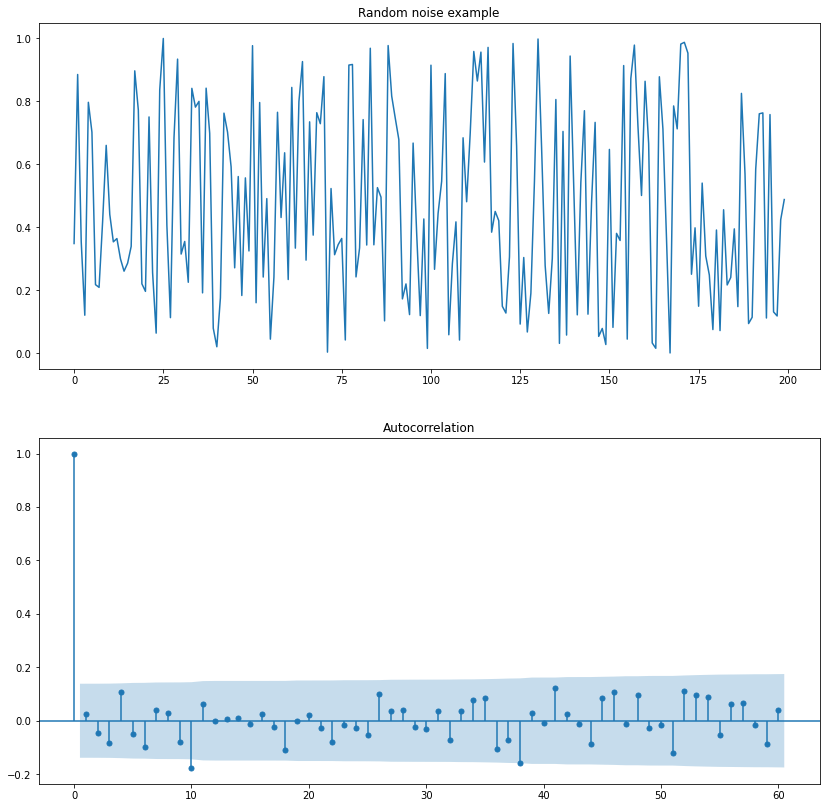

In [30]:
data_len = 200
random_noise = [np.random.random() for _ in range(data_len)]

plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Random noise example')
ax.plot(random_noise)

ax = plt.subplot(212)
plot_acf(random_noise, lags=60, ax=ax);

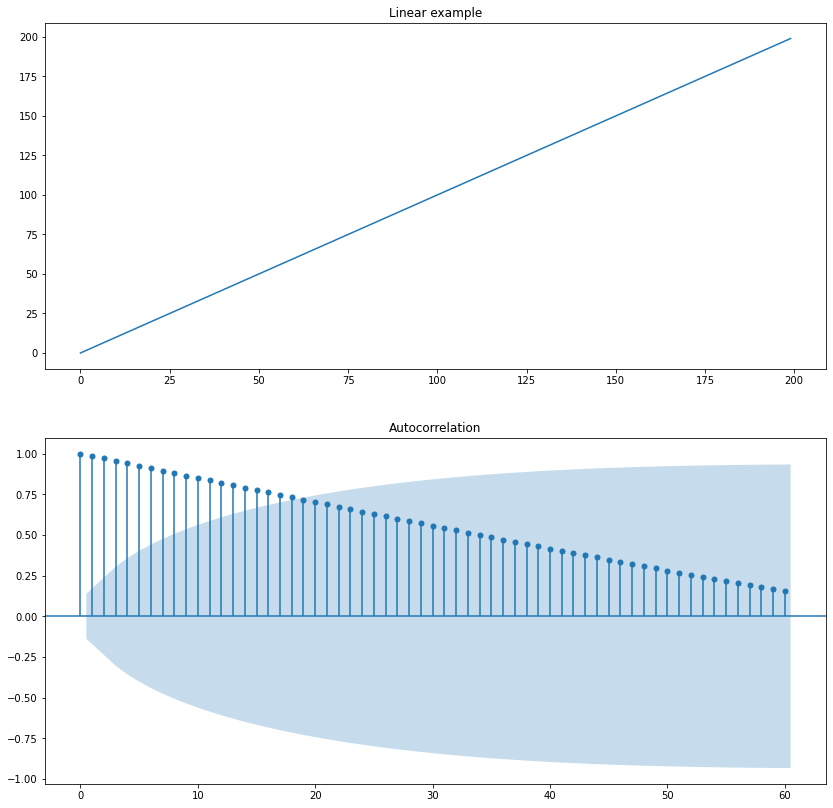

In [31]:
data_len = 200
linear_data = [i for i in range(data_len)]

plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Linear example')
ax.plot(linear_data)

ax = plt.subplot(212)
plot_acf(linear_data, lags=60, ax=ax);

Однако, наша основная задача &#151; предсказание значений временного ряда

Каким из известных вам способов можно было бы это сделать?

## Регрессия

### $$y_t = \sum_{i = 1}^{m}{\theta_i x_{t,i}}$$ 
где $\theta_i$ &#151; параметры модели, $x_{t, i}$ &#151; признаковое описание объекта 

Проблемы:
- все объекты обязаны быть независимы (попарно и в совокупности);
- во время обучения нельзя заглядывать в будущее (в случае кросс-валидации и деления на train-val-test выборки);
- вообще регрессионная модель -- не очень хороший выбор для решения этой задачи.

In [32]:
regression_df = df.copy()
regression_df = regression_df.drop(['HighDiff_1', 'HighLog', 'HighLogDiff_1'], axis=1)
regression_df.head()

,High
Date,
2015-04-01,40.76
2015-04-02,40.74
2015-04-06,41.78
2015-04-07,41.91
2015-04-08,41.69


In [33]:
X = regression_df.to_numpy()[:-1, :]
X.shape

(1510, 1)

In [34]:
y = np.squeeze(regression_df.to_numpy()[1:])
y.shape

(1510,)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [36]:
X_train[1, 0], y_train[0]

(40.74, 40.74)

In [37]:
X_test[5, 0], y_test[4]

(137.66, 137.66)

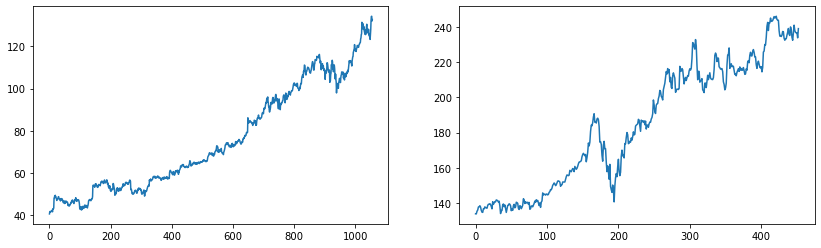

In [38]:
plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 4))

ax = plt.subplot(121)
ax.plot(y_train)

ax = plt.subplot(122)
ax.plot(y_test);

In [39]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression.coef_

array([1.00075351])

In [40]:
def make_prediction(regressor, starting_point, predictions_count):
    point = copy.deepcopy(starting_point)
    
    predicted_points = [point]
    
    for _ in range(predictions_count):
        predicted_value = regressor.predict([predicted_points[-1]])[0]
        predicted_point = [predicted_value]
        predicted_points.append(np.array(predicted_point, dtype=np.float64))
    
    return np.array(predicted_points, dtype=np.float64)

In [41]:
make_prediction(linear_regression, X_test[0], 10)[:, 0]

array([132.67      , 132.79978346, 132.92966471, 133.05964382,
       133.18972088, 133.31989595, 133.45016911, 133.58054043,
       133.71100999, 133.84157786, 133.97224411])

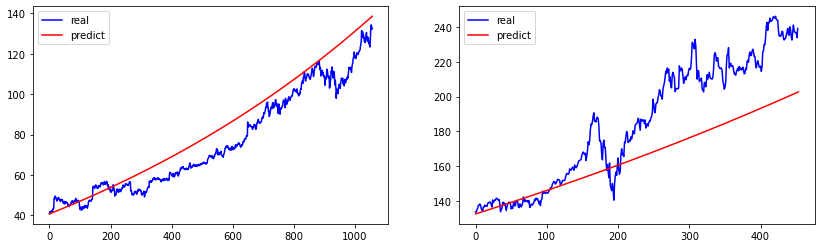

In [42]:
plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 4))


ax = plt.subplot(121)
ax.plot(y_train, c='b', label='real')
ax.plot(make_prediction(linear_regression, X_train[0], y_train.shape[0]), c='r', label='predict')
ax.legend()

ax = plt.subplot(122)
ax.plot(y_test, c='b', label='real')
ax.plot(make_prediction(linear_regression, X_test[0], y_test.shape[0])[:, 0], c='r', label='predict')
ax.legend();

## ARMA

Использовать обыкновенную регрессию для предсказания значений временного ряда плохая идея.

Попробуем решать задачу регрессии на основе истории самого ряда:

### $$y_t = \alpha + \theta_1 y_{t-1} + \theta_2 y_{t-2}, \cdots, \theta_{p} y_{t-p} + \epsilon_t$$ 
где $\alpha, \theta_i$ &#151; параметры модели

Такая модель для предсказания значений $y_t$ называется моделью авторегрессии с гиперпараметром $p$, **AR(p)**.

Ещё одна идея:

Попробуем решать задачу регрессии на основе истории остатков ряда:

### $$y_t = \alpha + \gamma_1 \epsilon_{t-1} + \gamma_2 \epsilon_{t-2}, \cdots, \gamma_{q} \epsilon_{t - q} + \epsilon_t$$ 
где $\alpha, \gamma_i$ &#151; параметры модели

Такая модель для предсказания значений $y_t$ называется моделью скользящего среднего с гиперпараметром $q$, **MA(q)**.

Вопросы:

- Зачем нужна вторая модель?
- Как обучать эти модели?

Если же мы представим $y_t$ в следующем виде:

### $$y_t = \alpha + \theta_1 y_{t-1} + \theta_2 y_{t-2}, \cdots, \theta_{p} y_{t-p} + \gamma_1 \epsilon_{t-1} + \gamma_2 \epsilon_{t-2}, \cdots, \gamma_{q} \epsilon_{t-q} + \epsilon_t$$ 

где $\alpha, \theta_i, \gamma_i$ &#151; параметры модели, то мы получим модель под названием **ARMA(p, q)** с гиперпараметрами $p$ и $q$.

### Теорема Вольда: Любой стационарный ряд может быть описан моделью ARMA(p, q) при правильно подобранных параметрах p и q

Вопросы: 
- Что делать с нестационарными рядами?
- Как подбирать параматры $p$ и $q$?

## ARIMA

Основные идеи, которые лежат в основе модели ARIMA:

- если мы имеем стационарный ряд, то мы можем использовать модель ARMA(p, q);
- если ряд нестационарен, то ряд его производных (сезонных или обычных) может оказаться стационарным.

### ARIMA(p, d, q) &#151; ARMA(p, q), которая применяется к исходному ряду, продиффериенцированному $d$ раз.

## SARMA

Пусть исходный ряд имеет сезонность длины $S$.

Добавим к модели **ARMA(p, q)** $P$ сезонных авторегресионных компонент и $Q$ сезонных компонент скользащего среднего

тогда формула для $y_t$ будет выглядеть следующим образом:

### $$y_t = \alpha + \theta_1 y_{t-1} + \theta_2 y_{t-2}, \cdots, \theta_{p} y_{t-p} + \\ \theta_S y_{t-S} + \theta_{2S} y_{t-2S}, \cdots, \theta_{PS} y_{t-PS} + \\ \gamma_1 \epsilon_{t-1} + \gamma_2 \epsilon_{t-2}, \cdots, \gamma_{q} \epsilon_{t-q} + \\ \gamma_S \epsilon_{t-S} + \gamma_{2S} \epsilon_{t-2S}, \cdots, \gamma_{QS} \epsilon_{t-QS} + \epsilon_t$$ 

где $\alpha, \theta_i, \gamma_i$ &#151; параметры модели

Такая модель для предсказания значений $y_t$ является моделью **SARMA(p, q, P, Q)**.

## SARIMA (последнее обобщение)

Пусть исходный ряд также имеет сезонность длины $S$.

Добавим к модели **ARIMA(p, d, q)** $P$ сезонных авторегресионных компонент, $Q$ сезонных компонент скользащего среднего и применим сезонное дифференцирование $D$ раз.

Такая модель для предсказания значений $y_t$ является моделью **SARIMA(p, d, q, P, D, Q)**.

### **SARIMA(p, d, q, P, D, Q)** &#151; **SARMA(p, q, P, Q)**, которая применяется к исходному ряду, продиффериенцированному $D + d$ раз.

Вопрос: 
- как выбирать параметры p, d, q, P, D и Q?

## Подбор параметров для алгоритмов

###  1. Параметры $\alpha$, $\theta_i$, $\gamma_i$

- данные параметры подбираются при помощи метода наименьших квадратов (МНК);
- особый интерес представляют параметры $\gamma_i$, так как $\epsilon_t$ не может быть пронаблюдаем нами (это просто шум);
- для этого параметры $\gamma_i$ оцениваются с помощью анализа остатков, который был произведён после обучении модели **AR(p, P)**;
- если шум белый, то МНК даёт оценки максимального правдоподобия (это круто).

### 2. Параметры d, D

- подобрать так, чтобы ряд стал стационарным (брутфорс?);
- стоит начинать именно с сезонного дифференцирования (параметра $D$);
- чем меньше мы в итоге продифференцируем, тем лучше будет итоговая модель.

### 3. Параметры q, Q, p, P

- нельзя подбирать эти параметры только на основе оценки правдоподобия (почему?);
- обычно для их выбора используют критерий Акаике: $AIC = -2\log{L} + 2 \cdot(P + Q + p + q + 1)$;
- начальные значения можно выбрать используя автокорреляцию;
- после этого параметры q, Q, p, P подбираются простым перебором.

- $Q \cdot S$ &#151; номер последнего сезонного лага, для которого автокорреляция значима;
- $q$ &#151; номер последнего несезонного лага, для которого автокорреляция значима;
- $P \cdot S$ &#151; номер последнего сезонного лага, для которого частичная автокорреляция значима;
- $p$ &#151; номер последнего несезонного лага, для которого частичная автокорреляция значима.

## Анализ остатков

**Остатки** &#151; разность между фактическим значением и прогнозируемым.

### $$\hat{\epsilon_t} = y_t - \hat{y_t}$$

Предположения, которым должны подчиняться остатки:

- несмещенность (равенство среднего значения остатков нулю). Можно проверить как визуально, так и с помощью двустороннего критерия Стьюдента или Уилкоксона. Если не выполняется, то можно вручную сдвинуть значения модели на среднее от остатков;
- стационарность (отсутствие зависимости от времени). Можно проверить как визуально, так и с критерия Дики-Фуллера. Если не выполняется, то точность модели зависит от времени. Необходим визуальный анализ;
- неавтокоррелируемость (отсутствие зависимости от предыдущих остатков). 

## Пример задачи прогнозирования

In [43]:
df = pd.read_csv('./example_data_2.csv')
df.head(13)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
5,06-01-1985,58.0904
6,07-01-1985,62.6202
7,08-01-1985,63.2485
8,09-01-1985,60.5846
9,10-01-1985,56.3154


In [44]:
df['Date'] = pd.to_datetime(df['DATE'], format='%m-%d-%Y')
df = df.set_index(['Date'])
df = df.drop(['DATE'], axis=1)
df.head()

,Value
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


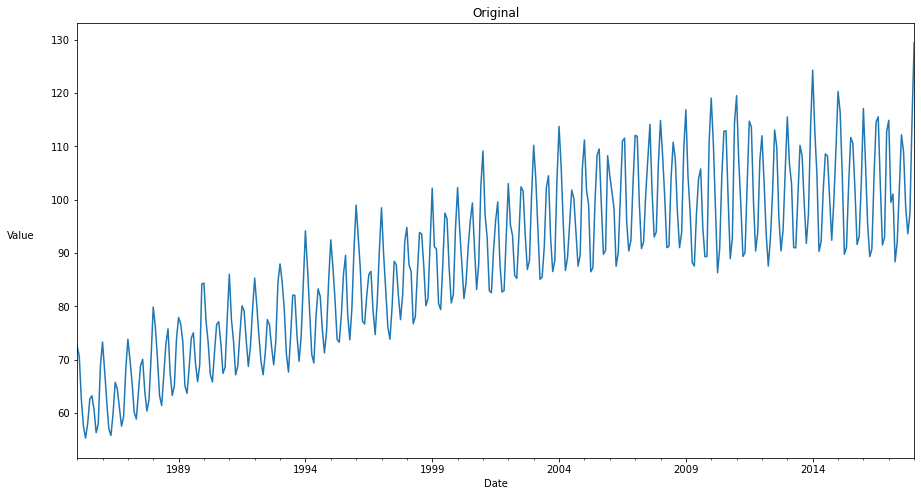

In [45]:
plt.figure(figsize=(15, 8))
plt.title('Original')
plt.ylabel('Value', rotation=0, labelpad=30)
df['Value'].plot();

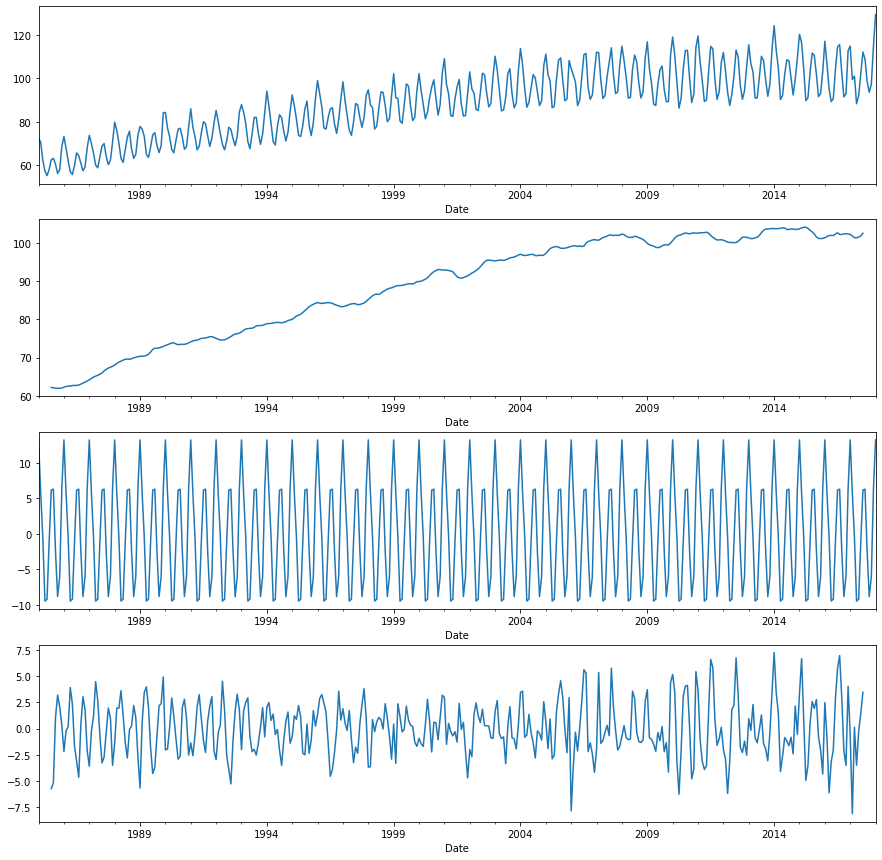

In [46]:
plt.figure(figsize=(15, 15))
decomposition = seasonal_decompose(df['Value'])

ax = plt.subplot(411)
decomposition.observed.plot(ax=ax)

ax = plt.subplot(412)
decomposition.trend.plot(ax=ax)

ax = plt.subplot(413)
decomposition.seasonal.plot(ax=ax)

ax = plt.subplot(414)
decomposition.resid.plot(ax=ax);

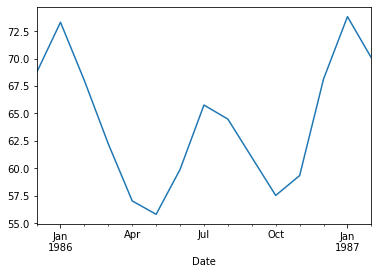

In [47]:
df['Value'][11:26].plot();

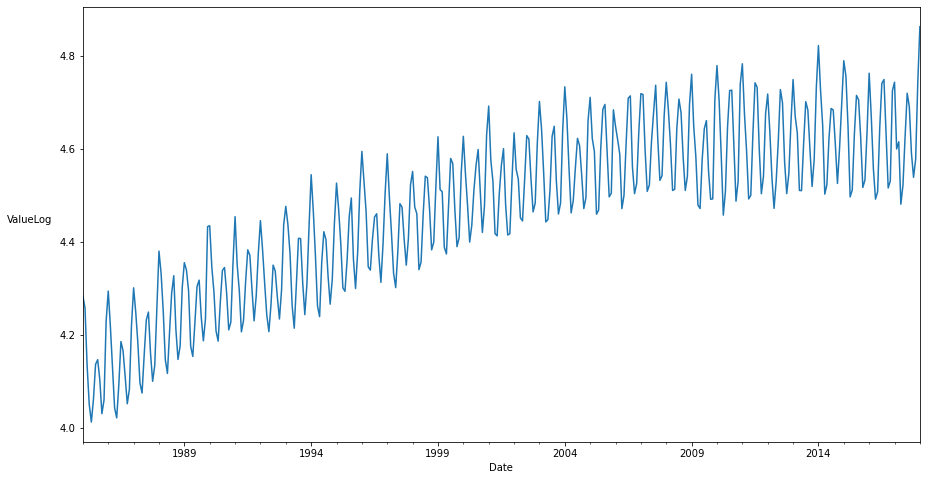

In [48]:
df['ValueLog'] = np.log(df['Value'])

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLog', rotation=0, labelpad=30)
df['ValueLog'].plot();

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


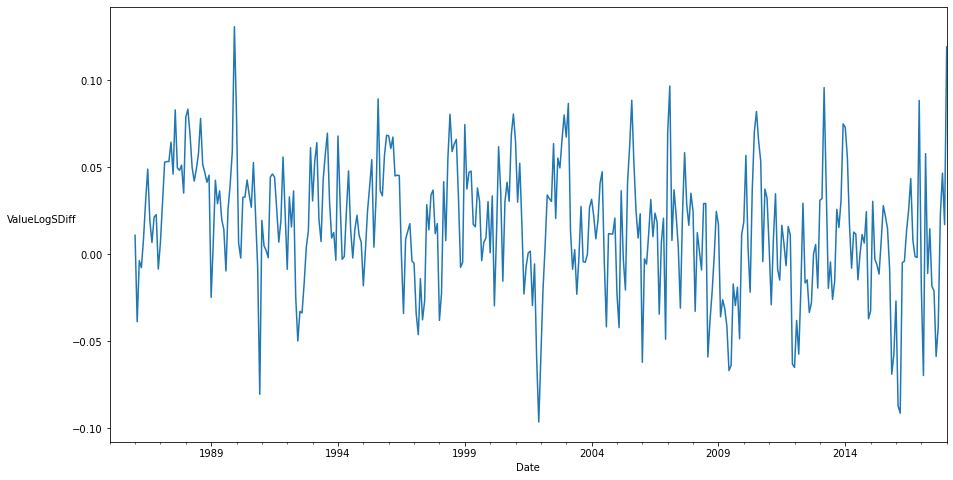

In [49]:
df['ValueLogSDiff'] = df['ValueLog'] - df['ValueLog'].shift(12)
p_value = adfuller(df["ValueLogSDiff"][12:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiff', rotation=0, labelpad=30)
df['ValueLogSDiff'].plot();

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


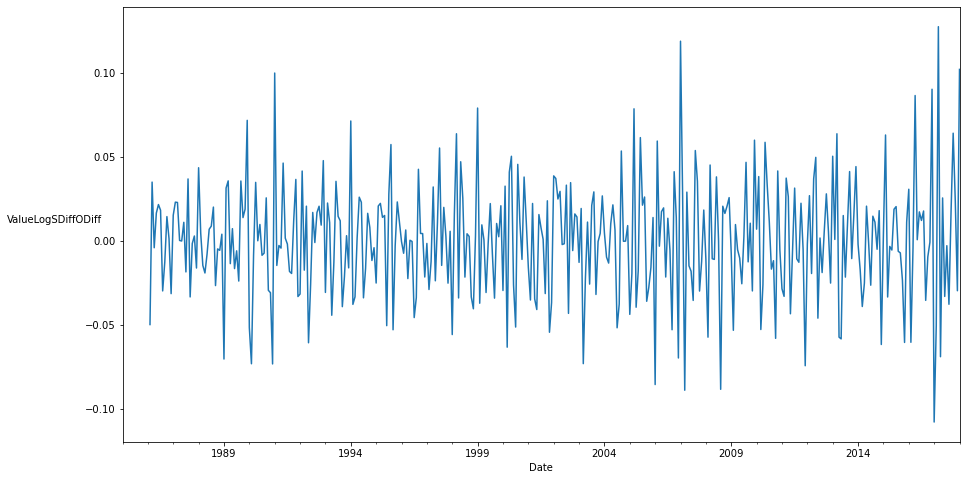

In [50]:
df['ValueLogSDiffODiff'] = df['ValueLogSDiff'] - df['ValueLogSDiff'].shift(1)
p_value = adfuller(df["ValueLogSDiffODiff"][13:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiffODiff', rotation=0, labelpad=30)
df['ValueLogSDiffODiff'].plot();

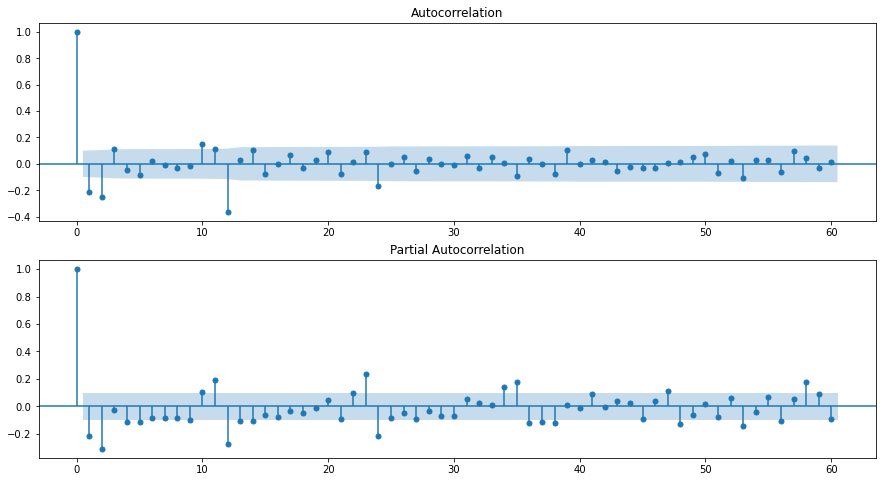

In [51]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(df['ValueLogSDiffODiff'][13:], lags=60, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(df['ValueLogSDiffODiff'][13:], lags=60, ax=ax);

In [52]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [53]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [61]:
%%time
#warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df['ValueLog'], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|█▎                                                                                 | 1/64 [00:04<04:54,  4.67s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:52

 17%|██████████████                                                                    | 11/64 [01:10<05:45,  6.53s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 19%|███████████████▍                                                                  | 12/64 [01:19<06:23,  7.38s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:52

C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 34%|████████████████████████████▏                                                     | 22/64 [02:29<04:37,  6.60s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

 50%|█████████████████████████████████████████                                         | 32/64 [03:50<04:49,  9.04s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 52%|██████████████████████████████████████████▎                                       | 33/64 [03:55<04:03,  7.84s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:52

C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|███████████████████████████████████████████████████████                           | 43/64 [05:18<03:02,  8.68s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

 83%|███████████████████████████████████████████████████████████████████▉              | 53/64 [06:52<01:39,  9.06s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 84%|█████████████████████████████████████████████████████████████████████▏            | 54/64 [07:01<01:29,  8.96s/it]C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:52

C:\Users\kabanchik\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [09:00<00:00,  8.44s/it]

Wall time: 9min


In [62]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
2   (1, 1, 4, 1) -1742.628007
0   (1, 1, 3, 1) -1741.455407
20  (2, 2, 3, 1) -1740.221431
36  (3, 2, 3, 1) -1738.649425
24  (2, 3, 3, 1) -1738.304226


In [63]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           ValueLog   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 879.314
Date:                            Wed, 06 Oct 2021   AIC                          -1742.628
Time:                                    18:29:34   BIC                          -1711.023
Sample:                                01-01-1985   HQIC                         -1730.092
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5024      0.058      8.621      0.000       0.388       0.617
ma.L1         -0.9242      0.029   

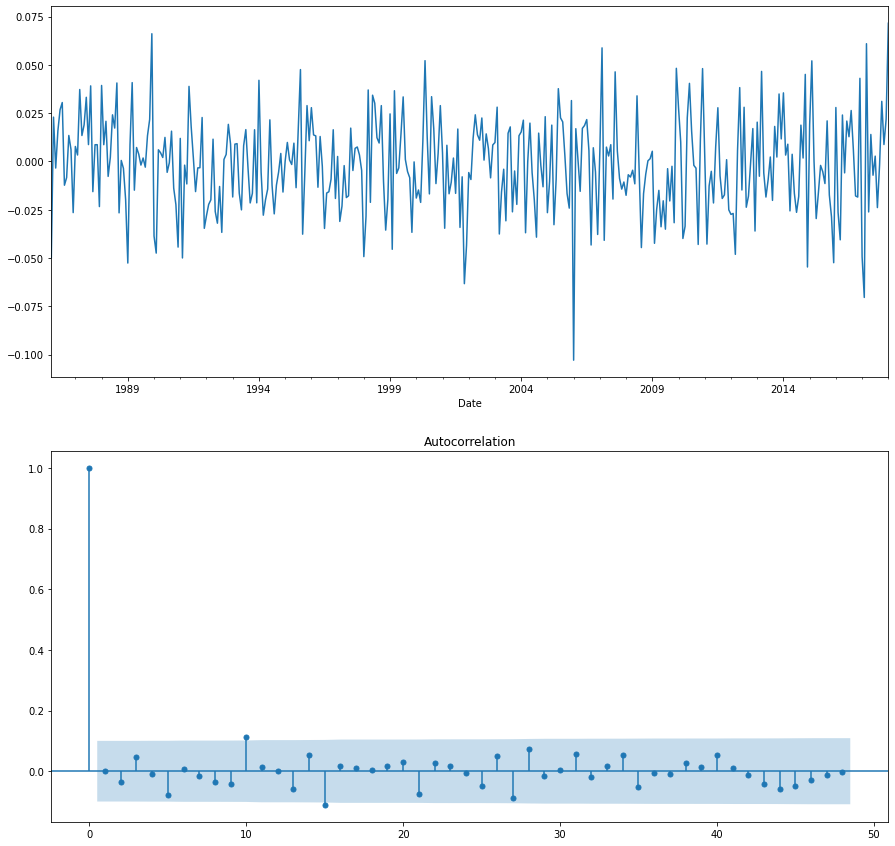

In [64]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax);

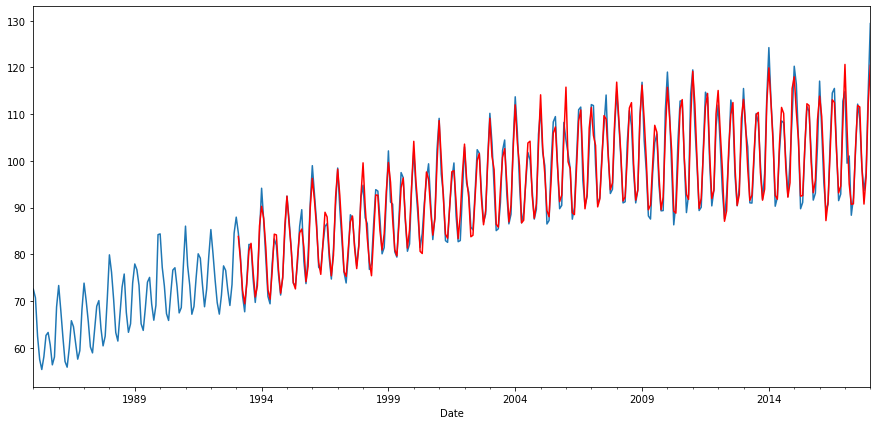

In [65]:
df['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

df['Value'][-400:].plot()
df['Model'][-300:].plot(c='r');

In [66]:
print(df.shape)
df.tail()

(397, 5)


,Value,ValueLog,ValueLogSDiff,ValueLogSDiffODiff,Model
Date,,,,,
2017-09-01,98.6154,4.591227,-0.041205,0.017487,98.786217
2017-10-01,93.6137,4.539177,0.022983,0.064188,90.746068
2017-11-01,97.3359,4.578168,0.046752,0.023769,96.486546
2017-12-01,114.7212,4.742505,0.017160,-0.029592,112.229663
2018-01-01,129.4048,4.862945,0.119314,0.102154,120.470930


In [67]:
predict_len = 120

new_close_value = df[['Value', 'Model']]
future_date = [
    datetime.datetime.strptime("2018-02-01", "%Y-%m-%d") + relativedelta(months=x)
    for x in range(0, predict_len)
]

future_df = pd.DataFrame(index=future_date, columns=['Value', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(517, 2)


,Value,Model
2027-09-01,NaN,NaN
2027-10-01,NaN,NaN
2027-11-01,NaN,NaN
2027-12-01,NaN,NaN
2028-01-01,NaN,NaN


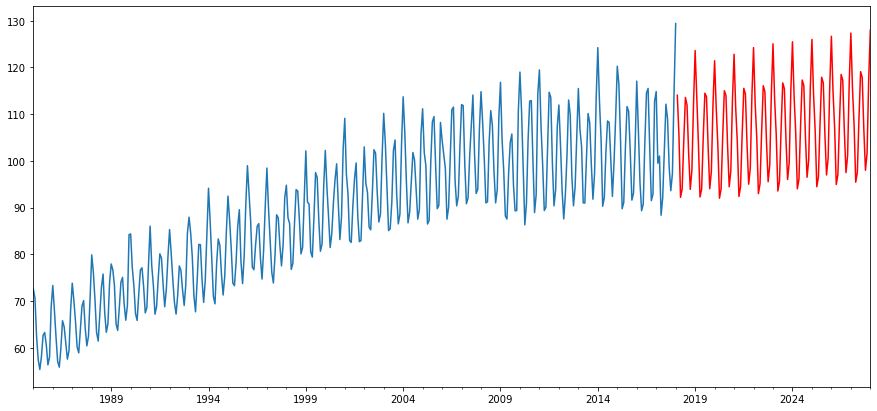

In [68]:
new_close_value['Model'] = np.exp(best_model.predict(start=397, end=397 + predict_len - 1))

plt.figure(figsize=(15,7))
new_close_value['Value'].plot()
new_close_value['Model'].plot(c='r');